#CHECKGPT DATASET (SAME AS THE ORIGINAL PAPER) WAS USED FOR FINE-TUNING AUTHORMIST

In [1]:
!git clone https://github.com/liuzey/CheckGPT-v2.git

Cloning into 'CheckGPT-v2'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 145 (delta 14), reused 29 (delta 9), pack-reused 107 (from 1)
Receiving objects: 100% (145/145), 1.10 GiB | 27.91 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (68/68), done.


In [2]:
!pip install datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Imports

In [1]:
from transformers import (pipeline, AutoTokenizer, AutoModel, AutoModelForCausalLM)
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import argparse
import gc
from datasets import Dataset
from trl import GRPOConfig, GRPOTrainer
from sklearn.model_selection import train_test_split
import json
import os
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig

In [2]:
# Clear memory at start
gc.collect()
torch.cuda.empty_cache()

### Preparing the dataset using CHECKGPT

In [3]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Function to create paraphrase prompt
def create_paraphrase_prompt(text: str) -> str:
    return f"""Please paraphrase the following text to make it more human-like while preserving the original meaning:
{text}
Paraphrased text:"""

# Load and prepare data
print("Loading data...")

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

# Limit dataset size to prevent OOM
max_samples = 300
if len(ai_texts) > max_samples:
    print(f"Limiting dataset to {max_samples} samples to prevent OOM")
    ai_texts = ai_texts[:max_samples]

# Split AI texts into train/test
train_texts, test_texts = train_test_split(ai_texts, test_size=0.2, random_state=42)

# Attach paraphrasing prompt to AI texts
train_texts = [create_paraphrase_prompt(text) for text in train_texts]
test_texts = [create_paraphrase_prompt(text) for text in test_texts]

# Create datasets
train_dataset = Dataset.from_dict({"prompt": train_texts})
test_dataset = Dataset.from_dict({"prompt": test_texts})

print(f"Training samples: {len(train_texts)}")

Loading data...
Limiting dataset to 300 samples to prevent OOM
Training samples: 240


### GRPO Config being setup along with PEFT

In [4]:
# Initialize the RADAR detector as None - will be loaded on first use
radar_detector = None

# Configure training with optimized settings for memory efficiency
print("Configuring training...")
training_args = GRPOConfig(
    output_dir="checkpoints/",
    logging_steps=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    fp16=True,
    optim="adamw_torch",
    gradient_checkpointing=True,
    max_grad_norm=0.5,
    remove_unused_columns=False,
    dataloader_num_workers=1,
    save_total_limit=1,
    save_strategy="epoch",
    eval_strategy="no",
    num_generations=2,
)

# Define PEFT configuration for LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=128,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

Configuring training...


### RADAR and DetectGPT are used as detectors along with the SemanticSimilarityChecker

In [5]:
# Define multiple detector classes
class Radar():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading RADAR model...")
            self.judge_model = pipeline(
                "text-classification",
                model="TrustSafeAI/RADAR-Vicuna-7B",
                tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("RADAR model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "LABEL_0" else 1 - score["score"])
            for score in scores
        ]

# Add another detector class (example for an OpenAI-based detector)
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

# Add a semantic similarity checker
class SemanticSimilarityChecker():
    def __init__(self, device="cpu"):
        self.device = device
        self.model = None
        self.tokenizer = None

    def _load_model(self):
        if self.model is None:
            print("Loading Semantic Similarity model...")
            self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
            print("Semantic Similarity model loaded successfully")

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, texts):
        self._load_model()
        encoded_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(self.device)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return self._mean_pooling(model_output, encoded_input['attention_mask'])

    def compute_similarity(self, original_texts, paraphrased_texts):
        # Get original texts from prompts (assuming prompt format is the same as in your code)
        extracted_originals = []
        for prompt in original_texts:
            text_start = prompt.find("following text:") + len("following text:")
            text_end = prompt.find("Paraphrased text:")
            extracted_originals.append(prompt[text_start:text_end].strip())

        original_embeddings = self.get_embeddings(extracted_originals)
        paraphrased_embeddings = self.get_embeddings(paraphrased_texts)

        # Compute cosine similarity
        similarities = []
        for i in range(len(original_embeddings)):
            similarity = F.cosine_similarity(original_embeddings[i].unsqueeze(0),
                                            paraphrased_embeddings[i].unsqueeze(0)).item()
            similarities.append(similarity)

        return similarities

# Initialize all detectors as None - will be loaded on first use
radar_detector = None
detectgpt_detector = None
semantic_checker = None

# Define a comprehensive reward function that combines multiple detectors
def multi_detector_reward_func(completions, prompts=None, **kwargs):
    global radar_detector, detectgpt_detector, semantic_checker

    # Initialize detectors if needed
    if radar_detector is None:
        radar_detector = Radar(device="cpu")
    if detectgpt_detector is None:
        detectgpt_detector = DetectGPT(device="cpu")
    if semantic_checker is None:
        semantic_checker = SemanticSimilarityChecker(device="cpu")

    # Process in smaller batches to reduce memory usage
    batch_size = 16
    all_rewards = []

    for i in range(0, len(completions), batch_size):
        batch_completions = completions[i:i+batch_size]
        batch_prompts = prompts[i:i+batch_size] if prompts else None

        # Get detector scores (lower is better - represents AI probability)
        radar_scores = radar_detector.score(batch_completions)
        detectgpt_scores = detectgpt_detector.score(batch_completions)

        # Calculate semantic similarity (higher is better)
        if prompts:
            semantic_scores = semantic_checker.compute_similarity(batch_prompts, batch_completions)
        else:
            semantic_scores = [1.0] * len(batch_completions)  # Default if no prompts

        # Calculate combined rewards
        for j in range(len(batch_completions)):
            # Detector rewards (higher is better - represents human-likeness)
            detector_reward = 0.5 * (1.0 - radar_scores[j]) + 0.5 * (1.0 - detectgpt_scores[j])

            # Semantic preservation reward (higher is better)
            semantic_reward = semantic_scores[j]

            combined_reward = 0.7 * detector_reward + 0.3 * semantic_reward

            all_rewards.append(combined_reward)

        # Clear memory after each batch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_rewards

# **Fine-tuning Authormist**

In [ ]:
!pip install -U bitsandbytes

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import get_peft_model  # Make sure to import this
print("Loading merged model...")
model = AutoModelForCausalLM.from_pretrained(
    "merged-authormist",
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

tokenizer = AutoTokenizer.from_pretrained("merged-authormist")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading merged model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import get_peft_model
import gc

# First, make sure to clear any existing models from GPU memory
gc.collect()
torch.cuda.empty_cache()
print("Cleared CUDA memory")

Cleared CUDA memory


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import get_peft_model

# Load the merged model directly
print("Loading merged model...")
model = AutoModelForCausalLM.from_pretrained(
    "merged-authormist",
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("merged-authormist")

# Load model for single-device training
print("Loading model...")
try:
    # Apply LoRA adapters to the model
    print("Applying LoRA adapters to model...")
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    print("Model with LoRA adapters loaded successfully")

    # Create a new GRPO config without model_init_kwargs
    from trl.trainer import GRPOConfig  # Import the specific config class

    # Extract the original configuration
    original_dict = training_args.to_dict()

    # Remove model_init_kwargs if present
    if 'model_init_kwargs' in original_dict:
        print("Removing model_init_kwargs from config")
        del original_dict['model_init_kwargs']

    # Create a new config with the modified dict
    new_training_args = GRPOConfig(**original_dict)

    # Initialize trainer with the new config
    print("Initializing trainer...")
    trainer = GRPOTrainer(
        model=model,
        reward_funcs=multi_detector_reward_func,
        args=new_training_args,  # Use the new config without model_init_kwargs
        train_dataset=train_dataset,
        processing_class=tokenizer,
        peft_config=peft_config,
    )

    print("Starting training...")
    trainer.train()

    print("Training completed successfully!")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

Loading merged model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading model...
Applying LoRA adapters to model...
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607
Model with LoRA adapters loaded successfully
Removing model_init_kwargs from config
Initializing trainer...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:2058: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'merged-authormist' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sps205039 (sps205039-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`generation_config` default values have been modified to match model-specific defaults: {'top_k': 20, 'top_p': 0.8, 'repetition_penalty': 1.05, 'bos_token_id': 151643}. If this is not desired, please set these values explicitly.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Loading RADAR model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


RADAR model loaded successfully
Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully
Loading Semantic Similarity model...
Semantic Similarity model loaded successfully


Step,Training Loss
3,0.000000
6,0.000000
9,0.000000
12,0.000000
15,0.000000


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Training completed successfully!


In [108]:
# Load model for single-device training
print("Loading model...")
try:
    # Load the base model first
    """model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",  # Keep this to automatically use available device
        load_in_8bit=True,  # Keep quantization for memory efficiency
        low_cpu_mem_usage=True
    )
    tokenizer = AutoTokenizer.from_pretrained("authormist/authormist-originality")"""

    # Apply LoRA adapters to the model
    print("Applying LoRA adapters to model...")
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    print("Model with LoRA adapters loaded successfully")

    # Initialize trainer without DeepSpeed
    print("Initializing trainer...")
    trainer = GRPOTrainer(
        model=model,
        reward_funcs=multi_detector_reward_func,
        args=training_args,
        train_dataset=train_dataset,
        processing_class=tokenizer,
        peft_config=peft_config,
    )

    print("Starting training...")
    trainer.train()

    print("Training completed successfully!")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

Loading model...
Applying LoRA adapters to model...
trainable params: 0 || all params: 3,115,872,256 || trainable%: 0.0000
Model with LoRA adapters loaded successfully
Initializing trainer...
Training error: You passed `model_init_kwargs` to the `GRPOConfig`, but your model is already instantiated. This argument can only be used when the `model` argument is a string.


Traceback (most recent call last):
  File "<ipython-input-108-84627e2199f4>", line 23, in <cell line: 0>
    trainer = GRPOTrainer(
              ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/trl/trainer/grpo_trainer.py", line 403, in __init__
    raise ValueError(
ValueError: You passed `model_init_kwargs` to the `GRPOConfig`, but your model is already instantiated. This argument can only be used when the `model` argument is a string.


### Saving and loading the fine-tuned model

In [9]:
# First, save the model with its adapter configuration
output_dir = "fine-tuned-authormist"  # Use a different directory name without slash at the end
os.makedirs(output_dir, exist_ok=True)

# Save the LoRA model properly
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# Now for merging, load the model correctly
try:
    # Load the base model
    base_model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",
        load_in_8bit=False  # Don't use 8-bit for saving
    )

    # Load the LoRA adapters from the saved directory
    merged_output_dir = "merged-authormist"
    os.makedirs(merged_output_dir, exist_ok=True)

    # Properly load the PEFT model
    model = PeftModel.from_pretrained(base_model, output_dir)

    # Merge the weights
    merged_model = model.merge_and_unload()

    # Save the merged model
    merged_model.save_pretrained(merged_output_dir)
    tokenizer.save_pretrained(merged_output_dir)

    print(f"Merged model saved to {merged_output_dir}")

except Exception as e:
    print(f"Error saving or merging model: {e}")
    import traceback
    traceback.print_exc()

Model and tokenizer saved to fine-tuned-authormist


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Merged model saved to merged-authormist


In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    "merged-authormist",
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("merged-authormist")

# Set to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (rotary_emb):

## Getting AI and Human Generated text from our dataset

In [11]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

In [12]:
hum_texts = hum_texts[:150]
ai_texts = ai_texts[400:600]

## Loading AuthorMist (fine-tuned) as a Paraphraser for Testing

In [13]:
model_name = "merged-authormist"

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

# Set device to the first model device automatically
device = model.device

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
import csv
csv_filename = "paraphrased_results.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Original Text", "Paraphrased Text"])

    for i, ai_text in enumerate(tqdm(ai_texts, desc="Paraphrasing texts")):
            prompt = f"""Please paraphrase the following text to make it more human-like while preserving the original meaning.
(Provide ONLY the paraphrased text with no additional commentary or responses)

{ai_text}

Paraphrased text:"""

            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs.input_ids,
                    max_new_tokens=512,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )

            full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
            paraphrased_text = full_output.split("Paraphrased text:")[-1].strip()
            print(paraphrased_text)
            csv_writer.writerow([ai_text, paraphrased_text])
            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"Paraphrasing complete! Results saved to {csv_filename}")

Paraphrasing texts:   0%|          | 0/200 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


This paper introduces a new way of choosing representatives from large amounts of data using a combination of sparse graphs and geodesic distances on Grassmann manifolds. The main aim is to select a small subset of representative samples that reflect the essence of the whole dataset. To do this, we start by constructing a sparse graph from the data where nodes are data points and edges denote similarity between pairs of points. We then use clustering algorithms to find groups of closely related data points. Finally, we choose a representative element from each group by computing geodesic distances on the Grassmann manifold and picking the one closest to the mean of the group. Results show that our method works better than others in terms of both representing and efficiency. We expect this method to be useful in many tasks like summarizing data, visualizing and classifying large data sets where choosing good representatives is important.


Paraphrasing texts:   0%|          | 1/200 [00:09<30:05,  9.08s/it]

Thermodynamic RAM (T RAM) is a new computational system which uses principles from thermodynamics to perform computations. This has shown great potential to simulate neuron behavior. In this paper we explore the possibility of using T RAM to simulate processing in the cerebral cortex. We start by outlining the architecture and operation rules of T RAM and comparing them to other neuromorphic computers. Next we report on our implementation of T RAM for processing simulation using a simple model of visual cortex as a case study. Results show that T RAM can replicate some key aspects of processing such as selective attention, receptive fields and binocular rivalry. We also look into different parameters' impact on performance and discuss implications for further development of more complex models of cortical processing. Results suggest that T RAM could prove to be useful in studying mechanisms of cortical processing and may eventually result in better designed systems inspired by biology.

Paraphrasing texts:   1%|          | 2/200 [00:18<29:41,  9.00s/it]

This paper investigates the assembly of two kinds of tiles onto a lattice by using random placement and observes the formation of complex structures with emergent characteristics. Tiles are square shaped and have edges that are either sticky or nonsticky; these edges allow for different arrangements. Through random placement, researchers observe formation of different structures such as aperiodic tilings and quasi crystals. Analysis uses computer simulation and modeling to study assembly processes and assess effects of different variables like concentration of tiles and temperature on resultant structures. Results show promise for producing new materials with special properties through random assembly and contribute to the growing field of self assembling systems.


Paraphrasing texts:   2%|▏         | 3/200 [00:24<25:40,  7.82s/it]

Because there is growing need for efficient computing, different approaches have been developed for allocating virtual machines (VMs) in cloud computing environments. This paper presents a new method aiming at minimizing total busy times of VMs while energy consumption becomes a major consideration. We formulate this into an optimization problem and design an algorithm that considers workloads and server energy consumption. The algorithm allocates VMs so that energy usage is balanced among servers while also minimizing total busy times. Performance evaluation using both real data and synthesized data shows that this proposed method works very well at reducing busy times and energy consumption significantly. Results from this research are important for designing efficient cloud computing systems.


Paraphrasing texts:   2%|▏         | 4/200 [00:31<24:18,  7.44s/it]

This paper investigates using stacked multilayer perceptrons (MLPs) for learning events that vary over time. Events which change over time include traffic patterns or weather changes. Proposed is an approach that trains a sequence of MLPs to learn different stages of dynamic event evolution. Each network's output feeds into the next so the system learns temporal dependency and improves prediction accuracy. Results from a dataset of traffic flow prediction indicate that stacked MLPs perform better than traditional methods like linear regression and support vector regression. Sensitivity tests also explore how performance varies depending on different settings for parameters and architecture. Overall findings suggest this approach works well for learning events that evolve dynamically; stacked MLPs have broad applicability to diverse tasks where events vary with time.


Paraphrasing texts:   2%|▎         | 5/200 [00:38<24:24,  7.51s/it]

Authors propose and assess an approach to study use of software in the social sciences using a knowledge graph. They emphasize importance of understanding tools and methods used in research and show how this graph allows integration and overview of software use in this discipline. They report results of their study, collecting and analyzing data from different places such as academic journals, software repositories and online discussion boards. Results indicate patterns and connections among software users, research topics and they show benefits for improving and innovating use of software in social sciences. In conclusion, authors say that graph approach useful for understanding software use and provides basis for further research and development work in this domain.


Paraphrasing texts:   3%|▎         | 6/200 [00:45<23:18,  7.21s/it]

This paper introduces an approach using deep reinforcement learning (DRL) for content caching in VECNs along with permissioned blockchains. This DRL algorithm optimizes caching strategies per vehicle by taking into account things like free space, content popularity and network conditions. Permissioned blockchains handle distribution and sharing of cached content and assure secure transactions among participants in this system. Simulation results indicate this proposed DRL caching method performs better than traditional methods in hit rates and energy efficiency. Combining DRL and permissioned blockchains thus suggests a promising solution for caching content within VECNs and greatly enhances system performance.


Paraphrasing texts:   4%|▎         | 7/200 [00:51<22:17,  6.93s/it]

This paper gives an extensive review of recent advances in querying paths in compressed graphs. It starts with a short introduction on why graph compression matters and where it finds use. The paper goes into detail about different approaches for compressing graphs such as adjacency lists and matrices and levels. The focus is on algorithms that process compressed graphs specifically and on balancing costs of time and space. Both exact and approximate algorithms are considered and performance metrics are compared using real data and simulated data. In conclusion the paper addresses remaining questions and points towards possible future research directions.


Paraphrasing texts:   4%|▍         | 8/200 [00:57<20:59,  6.56s/it]

This study performs empirical analysis on machine learning pipeline production and offers new insight into optimization opportunities. It assesses current condition of industrial pipelines and points out common issues and roadblocks. Through various experiments and case studies, researchers show impact of different optimization methods on performance and efficiency. Results show that using a combination of hardware and software optimization approaches like parallel processing and pruning improves both speed and accuracy of machine learning pipelines. Conclusions suggest practical recommendations for improving production pipelines and point to future research needs.


Paraphrasing texts:   4%|▍         | 9/200 [01:02<19:31,  6.13s/it]

This paper looks at comprehensive studies comparing systems for selecting features for algorithm selection focusing on evaluating performance of different methods for choosing best algorithms for specific optimization problems. Using a set of benchmark problems and a suite of algorithms, the study measures performance of these selection methods. Results show that systems that use features perform much better than using one algorithm alone. Results also reveal strengths and weaknesses of different selection methods and stress the importance of feature engineering. Findings from this research will help guide development of future systems for black box numerical optimization.


Paraphrasing texts:   5%|▌         | 10/200 [01:08<18:48,  5.94s/it]

This study introduces FILIP as a new model which uses fine integration of language and image models for better performance in tasks involving computer vision and NLP. FILIP combines both language and visual recognition models and is trained using a large corpus of text and images. Evaluation results on various benchmarks show marked improvement compared to current models; this indicates the effectiveness of the fine integration approach to training models combining language and vision. Results indicate that FILIP could prove useful across a broad spectrum of tasks within AI.


Paraphrasing texts:   6%|▌         | 11/200 [01:13<18:02,  5.73s/it]

This paper aims to conduct a comprehensive study on modeling beliefs in systems that change over time. It is divided into two sections: the first focuses on basic concepts. The authors start by defining belief and its importance within dynamic systems. They also review existing literature on modeling beliefs in these systems and discuss different approaches used. Next they introduce a framework for modeling beliefs in dynamic systems; this framework contains key elements including belief representation, updating belief and evaluating belief. It also considers aspects of uncertainty and ways of measuring this uncertainty. They also consider the challenges of modeling beliefs in systems that vary over time and list directions for future research. In summary, this paper lays a strong foundation for understanding how to model beliefs in systems that change. Authors review relevant literature and introduce a useful framework for both researchers and practitioners in this field. This paper i

Paraphrasing texts:   6%|▌         | 12/200 [01:22<21:01,  6.71s/it]

This paper looks at optimality of universal Bayesian sequence prediction for any given loss function and alphabet. It tries to establish conditions under which this Bayesian prediction method works well theoretically and gives a basis for proving optimality. First it explains what Bayesian prediction is and why it works. Then it defines the general loss function and alphabet and explains how they work in Bayesian prediction. Results are summarized and a theorem showing sufficient conditions for optimality is presented. Proving this theorem uses both math analysis and simulation results. Finally, conclusions are drawn about results and new lines of inquiry are pointed out.


Paraphrasing texts:   6%|▋         | 13/200 [01:28<20:18,  6.52s/it]

This paper reviews the latest research on social networks in an integrated way, focusing particularly on privacy issues. It looks at recent trends and development in this area and stresses that users increasingly worry about protecting personal information and that companies are under strong pressure to deal with these concerns. The paper also points out major challenges and opportunities for future work. These include the need to understand better what privacy means and how to manage it differently across various network contexts and potential new technology solutions to enhance privacy protection on those sites. Finally, the paper urges further research and cooperation among scholars, industry leaders, and policy makers regarding the important and urgent matter of privacy in social networking sites.


Paraphrasing texts:   7%|▋         | 14/200 [01:35<20:32,  6.63s/it]

This paper introduces a new way of classifying indoor scenes by using both spatial layout and scale invariant features. Spatial layout captures overall structure of the scene, while scale invariant features extract features which are less sensitive to scale changes. Combining these two approaches leads to a better and more accurate system for classification compared to previous methods. Experiments on different benchmarks show this new method performs better than leading ones.


Paraphrasing texts:   8%|▊         | 15/200 [01:39<18:17,  5.93s/it]

This research report looks into correlation patterns between pollutants and child cancer incidence. It uses a large dataset of pollution levels and cancer cases in a particular region. It explains how they identified relationships among these variables and reports the outcomes of their analysis. Results show strong clustering of high levels of certain pollutants with increased cancer incidence in the study region. Results from this work add to the discussion about environmental pollution effects on health and offer important data to policy makers and public health authorities for regulatory decision making.


Paraphrasing texts:   8%|▊         | 16/200 [01:44<17:26,  5.69s/it]

Cyclus archetypes are important in the study of nuclear fuel cycles. This paper reviews different ones that have been studied by other researches. We start by defining what they are and explain why they matter. Then we take a broad look at different types of archetypes such as once through, closed and open. We also look at benefits and drawbacks of each one and note any limitations or assumptions involved. Finally we discuss how this knowledge could affect future studies into nuclear fuel cycles and sustainable development of nuclear power systems.


Paraphrasing texts:   8%|▊         | 17/200 [01:50<17:07,  5.62s/it]

This paper introduces a new way to identify sources in systems where particles spread both by moving (advection) and diffusing randomly (diffusion). It combines machine learning with a method using Green functions and inverse problems. Supervised learning algorithms are used to estimate unknown release sources based on observed concentration data. Then Green function method is used to verify accuracy of estimated sources and reconstruct system parameters. Results show this new approach excels at both accuracy and speed compared to previous methods and thus promises to be a useful tool for finding sources in practical systems.


Paraphrasing texts:   9%|▉         | 18/200 [01:56<17:11,  5.67s/it]

This paper looks into dynamic beliefs; that is, how subjective probabilities of events or propositions change over time. It studies how to track and model such beliefs both individually and among groups. Methods rely on Bayesian belief networks and probabilistic graphs, which have been successful frameworks for dealing with uncertainty and updating beliefs. Performance of these methods is evaluated via simulations and empirical studies and important factors affecting accuracy of extracting belief dynamics are also explored. Results of this research can help to develop better models for monitoring and understanding beliefs in practical situations like decision making, risk assessment and information sharing.


Paraphrasing texts:  10%|▉         | 19/200 [02:02<17:22,  5.76s/it]

This paper investigates how spectral efficiency is affected when there is correlation among desired and interfering signals that follow Gamma Lognormal distributions. It looks at the effect of this correlation on wireless communications systems. Results indicate that spectral efficiency drops sharply due to strong correlation between desired and interfering signals and leads to substantial performance degradation. A theoretical framework is developed to characterize efficiency under such conditions and provides insight into balance between correlation and efficiency. Results of this research are significant because they influence design and optimization of wireless communication systems and suggest guidelines for development of better performing and more robust systems.


Paraphrasing texts:  10%|█         | 20/200 [02:08<17:22,  5.79s/it]

This paper develops a new geometric understanding of sensitivity analysis for monomials which are commonly used across diverse scientific and engineering disciplines. Based on an innovative interpretation of sensitivity matrix as subspaces of parameter space this work shows that dimensions and orientations of these subspaces contain important information about how sensitive outputs of the model are to variations of input parameters. Specifically, sensitivity is shown to depend on geometric features of the subspaces and amount of overlap among them. Results provide a fresh outlook on sensitivity analysis for monomials and introduce a practical framework for analysis and visualization of sensitivities in high dimensional parameter spaces. Numerical examples are also given and comparison with other approaches is made.


Paraphrasing texts:  10%|█         | 21/200 [02:14<18:17,  6.13s/it]

This paper looks at reducing interference in Cloud Radio Access Networks (C R ANs) using the splitting of rates combined with decoding of common messages. Splitting rates is a promising way to reduce interference and enhance spectral efficiency in wireless networks, but applying it to C R ANs has been difficult because coordination among Baseband Units (BBUs) and Remote Radio Heads (RR Hs) is complex. We propose joint design of splitting rates and common message decoding at BBU to reduce interference in these networks. We develop a new algorithm to optimize splitting rate parameters and coefficients for common message decoding to minimize total transmitted power and maintain QoS for all users. Results from simulations show significant performance improvement compared to other methods especially under dense and highly interfering conditions. Insights are gained regarding potential use of splitting rates and common message decoding for interference management and this knowledge informs d

Paraphrasing texts:  11%|█         | 22/200 [02:24<20:47,  7.01s/it]

This paper introduces a new way of compressing categorical features using submodular optimization. Features of this kind are very common in practice but they often cause high computational cost and storage demands in machine learning. Our approach uses submodular optimization to select an important subset of representative categories which capture most of the information from raw data. We formulate the problem as a maximization task using submodularity and develop a greedy algorithm for efficient solution finding. We also give theoretical assurance about quality of results from our algorithm. Results show that this method compares favorably against others in terms of both compression ratio and accuracy on different benchmarks. Our method is easy to integrate into current pipelines and has promise to greatly enhance efficiency and scalability for models working with categorical features.


Paraphrasing texts:  12%|█▏        | 23/200 [02:31<21:19,  7.23s/it]

This paper looks into structured mappings for sharing information among many users through multiple access channels. Specifically this work focuses on whether structured mappings offer advantages like efficient communication of shared information and reducing interference along with increasing channel capacity. A theoretical framework is presented for designing such mappings which balance well between conveying common information and channel resource requirements. Practical algorithms are also developed based on sparse graph codes for constructing such mappings. Results from simulations show that this method performs better in terms of rate achieved and decoding complexity compared to previous approaches. At the end the authors conclude that structured mappings are promising solutions to enhance efficiency and capacity of channels and they have potential uses in wireless networks and multimedia communications as well as others.


Paraphrasing texts:  12%|█▏        | 24/200 [02:38<21:03,  7.18s/it]

This paper introduces a new way of designing efficient artificial neurons using superconducting wires. The architecture includes a superconducting loop with a junction for adjustable response to inputs. The junction performs as an activation function and low power usage is obtained by using superconductivity to eliminate resistance in the loop. We develop a detailed model for the proposed neuron and perform extensive simulations to validate its performance characteristics. Results indicate high accuracy and much lower power consumption compared to other designs. We also develop a method for integrating many neurons into a larger network and demonstrate that this neuron architecture scales well to create high performance networks that consume less power. Overall this work opens promising avenues for development of energy efficient neural networks applicable to diverse fields including machine learning and cognitive computing.


Paraphrasing texts:  12%|█▎        | 25/200 [02:46<21:23,  7.34s/it]

This paper focuses on security of edge nodes in the Internet of Things (IoT) context. We investigate possible security attacks that can happen at edge nodes, which are small devices located near network edges collecting and processing data from other IoT devices. As machine learning becomes increasingly common in IoT, there is growing concern about system security because learning algorithms are vulnerable to different types of attacks. This paper looks into various types of attacks such as inference attacks, evasion attacks and poisoning attacks. We analyze impact of these attacks on performance of learning algorithms and how they can undermine security of IoT networks. Countermeasures proposed here aim to defend against these attacks. Countermeasures include using secure communication protocols, implementing security measures within machine learning algorithms and using secure hardware and software systems. Authors also point out challenges to effective implementation of these counte

Paraphrasing texts:  13%|█▎        | 26/200 [02:58<24:59,  8.62s/it]

This paper investigates how autonomous systems and AI can affect stability in the nuclear sector. It looks at how such systems might enhance safety and security and reduce risks of accidents and incidents. Also considered are challenges involved with integrating these systems including ethical issues and cybersecurity risks. Results show that integration of these systems can transform the nuclear sector and contribute toward a stable future. Careful planning and implementation strategies are needed to integrate them responsibly and safely. Collaboration between experts in both nuclear and technology domains is crucial for realizing the full benefits of these advanced technologies towards attaining a stable future.


Paraphrasing texts:  14%|█▎        | 27/200 [03:04<22:33,  7.82s/it]

This paper introduces an efficient sampling method based on polynomial chaos for quantifying uncertainties and analyzing sensitivities. Proposed method uses weighted approximations of Fekete points, known for their ability to distribute points evenly for interpolating polynomials. Using such points allows authors to show that proposed method achieves high accuracy with fewer samples than traditional Monte Carlo methods. Performance of this method is assessed by various numerical tests; results indicate that this approach is promising for efficient sampling in quantification of uncertainties and sensitivities using polynomial chaos.


Paraphrasing texts:  14%|█▍        | 28/200 [03:09<20:21,  7.10s/it]

This paper introduces a new way to improve security and robustness of communication for unmanned aerial vehicles (UAVs) using reconfigurable intelligent surfaces (RISs). The paper first reviews current challenges in UAV communications like interference and attack by jammers as well as weak signals. Next, the idea of RISs is introduced as a promising solution to these problems. Authors propose a secure and robust communication system for UAVs that uses RISs to adapt channel conditions on the fly. Performance of this proposed system is evaluated using simulations and experiments showing clear advantages such as improved signal quality, reliability and security compared to conventional UAV communication systems. Results from this study offer fresh insights into the value of RISs as critical technology for secure and reliable UAV communication.


Paraphrasing texts:  14%|█▍        | 29/200 [03:17<20:58,  7.36s/it]

This paper looks at hardness and approximation for probabilistic p centers when there are pressures. The p center problem is one of the classic ones in OR and CS; it finds the best location for p facilities in a network so that maximum distance to nearest facility is minimal. Probabilistic p centers extend this idea by considering probability distributions over demands at points in the network. Pressure means there are limitations or external things affecting decision making. First the paper defines probabilistic centers and related variants like standard and sensitive to pressure. Then it discusses computational complexity proving NP hardness via reductions from known hard problems. It introduces approximation algorithms for probabilistic centers with pressure and analyzes performance along with some numbers to show effectiveness. At last the authors summarize results and suggest future work. Results of this work contribute important insights into hardness and approximations for proba

Paraphrasing texts:  15%|█▌        | 30/200 [03:26<22:32,  7.96s/it]

This paper investigates design of constellation for Non Coherent MIMO Multiple Access Channels. The main goal is to improve system performance by optimizing constellation design for data transmission. A new joint design method which considers both channel state information and user pairing is proposed. Performance of this method is assessed via simulations and compared against other approaches. Results indicate clear improvement of Bit Error Rate (BER) especially at high SNR levels. Concluding that this joint constellation design shows promise and applicability in practice.


Paraphrasing texts:  16%|█▌        | 31/200 [03:32<20:02,  7.12s/it]

Symbolic Aggregate Approximation (SAX) has become popular for analyzing time series because it excels at both processing efficiency and capturing patterns. But limitations exist when it comes to detecting trend information at segments. We propose an improved SAX which integrates trend information aiming to enhance performance at capturing patterns in time series. Extensive testing and evaluation show that our new method performs better compared to traditional SAX both at global and local trends. Results from this study advance effective time series analysis methods and have practical significance for many real world tasks.


Paraphrasing texts:  16%|█▌        | 32/200 [03:37<18:37,  6.65s/it]

This paper introduces a new method for estimating crowd numbers using fusion of different resolution levels and use of priors across multiple scales. Proposed method combines strengths from fusion of various resolutions and use of priors at different scales to accurately estimate crowd size in a scene. Method uses capture of scenes at different resolutions and fuses information together to generate high resolution images. Further refinement of crowd estimation is achieved by use of priors at multiple scales. Results show this method performs better than current leading methods on different public datasets. This approach promises significant improvement for real world tasks like crowd management and safety monitoring.


Paraphrasing texts:  16%|█▋        | 33/200 [03:43<18:08,  6.52s/it]

This paper introduces a new method of deep metric learning for proxies to improve performance and scalability of recognition systems based on proxies. Previous methods use many proxy samples but this can be costly computationally and impractical for scalability. We propose "Less is More" learning of proxy examples into a compact feature space using deep graph metric learning models. Leveraging relationships among proxies we learn a low dimensional feature space that captures discriminative information per class with much fewer samples. Results show this method performs better than previous ones in both accuracy and efficiency using significantly less proxies. Our work points toward development of more efficient and scalable systems for object recognition.


Paraphrasing texts:  17%|█▋        | 34/200 [03:50<18:02,  6.52s/it]

This paper investigates unsupervised domain adaptation focusing on maximizing determinacy using classifiers. Goal is to train a model on a source domain where labeled data is available and then generalize performance to a target domain where there are no labels. A classifier that leverages decision boundaries learned by two classifiers trained separately on source and target domains is used to improve performance. We propose learning a decision boundary that maximizes consistency between these classifiers so that we reduce discrepancies between source and target domains. Results show this approach outperforms current best methods using experiments on different datasets. Conclusions highlight application areas including computer vision and NLP.


Paraphrasing texts:  18%|█▊        | 35/200 [03:56<17:49,  6.48s/it]

This paper introduces an innovative planning algorithm named e$ \mathbf{^3} $mop that integrates guided motion primitives pruning along with path optimization using a sparse banded structure. This algorithm is developed for high dimensional motion planning with complex constraints such as those relevant to robotics and autonomous systems. e$ \mathbf{^3} $mop begins by generating a set of primitives through heuristic guidance to reduce search space. Then this set of primitives is pruned using a new cost function that considers both the cost of the primitive and remaining path expected cost. This pruning greatly reduces consideration of primitives thus reducing computation time. Remaining primitives are used to construct a sparse banded graph capturing connectivity among them. Optimization of this graph uses a new method that exploits sparse banded structure to compute optimal path efficiently. Results show that e$ \mathbf{^3} $mop excels compared to leading algorithms regarding both per

Paraphrasing texts:  18%|█▊        | 36/200 [04:09<22:32,  8.25s/it]

This paper introduces an improved system for estimating curvature using level set method by combining traditional methods with machine learning. Level set method is commonly used in computer vision, medical imaging and graphics for modeling shapes and segmenting images. Curvature estimation is important here because it is necessary for proper propagation of level set functions. But traditional methods often have shortcomings such as being sensitive to noise and irregular sampling. To address this we propose a hybrid system that blends traditional curvature estimation with machine learning. Learning models are trained on a large set of both synthetic and real images and they learn to predict curvature at every point on evolving interface based on local features. Hybrid system mixes predictions from learning models with results from traditional methods and thus produces more accurate and robust results. Results on different data sets show that this hybrid system performs better compared 

Paraphrasing texts:  18%|█▊        | 37/200 [04:20<24:51,  9.15s/it]

This paper introduces a new approach to estimating depth unsupervisedly by using H-Net, which is a deep neural network with an attention mechanism, and using epipolar geometry. Depth estimation from stereo images is an important task in computer vision and has applications such as robotics and autonomous driving and 3D reconstruction. The proposed approach uses attention to focus on key parts of the images for estimating depth. Additionally, using epipolar geometry enforces geometric consistency on the estimated depths. Experimental results show this approach performs better compared to leading unsupervised methods on benchmark data sets. Also this approach is easy to adapt for other closely related tasks like flow estimation and super resolution. Results suggest that using H Net along with epipolar geometry is promising for unsupervised depth estimation with wide applicability in computer vision.


Paraphrasing texts:  19%|█▉        | 38/200 [04:28<24:09,  8.95s/it]

This paper introduces SCSGuard, a new approach using deep learning for spotting scams in smart contracts on Ethereum. Scams are problematic because they cost users big money. Previous methods usually rely on rules or static code analysis but SCSGuard uses a deep learning model to spot unusual patterns in bytecode. Performance is evaluated using a large dataset of known scams and clean code and training is done with supervised learning. Results show high performance compared to current best methods. Factors contributing to success include the choice of neural architecture, size and quality of dataset, and transfer learning. Limitations are also discussed; future work includes enhancing interpretability and evaluating robustness with adversarial examples. Overall we demonstrate that deep learning approaches have potential for detecting scams and suggest future research. We also think this system has great importance for making Ethereum ecosystem safer and more trustworthy. We hope future

Paraphrasing texts:  20%|█▉        | 39/200 [04:37<24:01,  8.95s/it]

This paper compares empirically four learning algorithms for collision prediction in a simulated 2D grid world: Q learning, SARSA, Expected SARSA and Double Q learning. Comparisons are made on a range of hyperparameters and performance is measured using metrics such as mean squared error and average reward. Results show that Expected SARSA performs best with regards to mean squared error and average reward whereas Double Q learning does poorly. Performance variation among algorithms is also observed to depend strongly on hyperparameters and sensitivity to them varies between algorithms. Overall this work conducts valuable empirical comparisons among these learning algorithms for collision prediction and suggests important insights regarding their relative merits and demerits. Insights gained are valuable for research and practice aiming at similar prediction tasks and may guide choice of appropriate algorithms for specific contexts.


Paraphrasing texts:  20%|██        | 40/200 [04:45<23:06,  8.67s/it]

In recent years self supervised learning has received significant attention as an effective way to deal with computer vision tasks without supervision. This paper introduces a new approach to tracking using target aware data synthesis. Proposed method synthesizes realistic training data by blending target object images with different backgrounds. Training data synthesized this way is then used to train a deep neural network which tracks targets in real time video. Network learns to distinguish target from background based on appearance, motion and contextual information. Results are compared against top performing current methods on benchmark datasets and show performance comparable to current methods and superior performance on hard cases. This work highlights that target aware data synthesis for supervised tracking is promising.


Paraphrasing texts:  20%|██        | 41/200 [04:52<21:29,  8.11s/it]

This paper investigates how to use two metrics, VMAF and ED, for assessing the quality of high frame rate videos. As high frame rate videos become more popular, it is important to have good ways to assess visual quality. These metrics have worked well for regular video before but there hasn't been much work done on their effectiveness with high frame rate. To test if they perform well, researchers asked 30 people to judge sequences of videos using the Absolute Category Rating method. They then compared their scores to those obtained by VMAF and ED metrics. Using videos of diverse genres and motions, the authors ensured reliability of results. Results show that both VMAF and ED perform reliably; they correlate very well with scores given by people using the AC rating method. VMAF performs slightly better but this difference is not statistically significant. This research improves objective methods for assessing quality of high frame rate videos, which will be helpful for compression and

Paraphrasing texts:  21%|██        | 42/200 [05:03<23:26,  8.90s/it]

This paper introduces a new method to improve security for systems of Industry 4.0 using Quorum Based Cloud Edge Distributed Deep Neural Network System (QUDOS). Recently, there is a growing demand for secure and efficient data processing because cloud services have become very popular in Industry 4.0. Existing solutions for security of such systems are inadequate to handle the complicated nature of threats. Authors propose QUDOS, a framework based on quorums for secure execution of deep neural networks (DNNs) in cloud and edge computing environments. QUDOS combines benefits from both clouds and edges to deliver secure and efficient processing of data in Industry 4.0. Using a consensus mechanism based on quorums ensures secure and decentralized execution of DNNs across different edge devices and cloud. This framework secures data processing by distributing execution of DNNs among different devices which reduces risks of single points of failure and data breaches. Secure multiparty compu

Paraphrasing texts:  22%|██▏       | 43/200 [05:18<28:25, 10.86s/it]

This paper introduces an approach to domain adaptation using unsupervised learning on time series data. The goal is to address issues related to domain shift and shortage of labeled data. This method uses intrinsic temporal relationships in time series data and adapts to new domains using unsupervised learning. No labeled data from target domain is required. The approach trains an unsupervised autoregressive model on source data; then it synthesizes new samples for target domain using this model. These synthetic samples are then used to train a model for domain adaptation, which minimizes the discrepancy between source and target domains. Results show that this method performs better than other methods on real datasets in terms of performance and robustness to domain shift. Study indicates that unsupervised autoregressive domain adaptation makes good use of temporal relationships within time series and offers promising solutions especially when labeled data is scarce or unavailable.


Paraphrasing texts:  22%|██▏       | 44/200 [05:27<26:47, 10.31s/it]

This paper analyzes filtering using consensus theory for agents that are interconnected in a network. The goal is to estimate a common signal from noisy measurements distributed among them. We present an algorithm for distributed filtering; each node updates its own estimate by combining its measurement with those from neighbors. There is a fusion step as well where these estimates are combined to get a global estimate of the signal. We study convergence properties of this algorithm and derive conditions under which the consensus estimate converges. We also look into how fusion affects accuracy of final results and derive error bounds. Through simulations we show effectiveness of the algorithm in noisy and changing environments for accurate estimation of common signals. The method applies to sensor networks, distributed control and systems of agents where common signal estimation is important.


Paraphrasing texts:  22%|██▎       | 45/200 [05:35<24:38,  9.54s/it]

This paper introduces a new method for exploring labeled graphs guided by user labels. This differs from previous methods which use a constant proportion of labels; this new method lets users change this proportion according to their specific needs and goals. The authors developed an algorithm that computes the best proportion of labels dynamically depending on the exploration progress. They consider different factors like graph density and label distribution along with user feedback to compute this proportion. Experiments on real data and synthetic data showed this method outperforms previous methods in both efficiency and accuracy especially when the best proportion is uncertain or varies over time. An experiment with users also found good results. In summary, this new method allows flexible and efficient navigation of large and complicated graphs useful for diverse applications such as social network analysis and bioinformatics.


Paraphrasing texts:  23%|██▎       | 46/200 [05:43<23:16,  9.07s/it]

This paper introduces an approach based on recurrence relations for analysis of effective capacity for schemes of retransmissions in wireless communication systems. Effective capacity measures the highest attainable rate of data transmission while adhering to strict limits on delays. We propose a computational tool that finds effective capacity for various schemes like ARQ and HARQ protocols. Effectiveness of our method has been validated by numerical examples and simulations; results show high accuracy and efficiency. Results from this research are very useful for designing efficient schemes and serve as reference material for future work in wireless communications.


Paraphrasing texts:  24%|██▎       | 47/200 [05:49<20:35,  8.08s/it]

This research studies maximum minimum distance of linear codes that allow local repair, aiming to set tight upper limits on this distance. Recent years have seen increased interest in codes that are resilient to faults and storage system design. Maximum minimum distance of a code is an important measure related to correction of errors. This paper carefully examines this distance and relates it to other code parameters. Designing codes also affects their value. Authors use different math tools to derive new bounds on this maximum minimum distance and test tightness of these bounds via numerical experiments. Results from this work give valuable insight into designing codes with better performance for correcting errors.


Paraphrasing texts:  24%|██▍       | 48/200 [05:55<19:14,  7.60s/it]

The off switch game is a straightforward two player game that has been researched in game theory and decision making. In this game, one player selects whether to turn off play or to keep playing while the other can choose to accept or reject that choice. Researchers discuss this game extensively including its mathematical formulation, equilibria and its use in different fields. Authors also introduce new ways to study the game and its variations and show their practical value via case studies and simulation. Results from these studies enhance our understanding of how people make decisions when they can opt out early and have relevance in bargaining and social dynamics among others.


Paraphrasing texts:  24%|██▍       | 49/200 [06:02<18:09,  7.22s/it]

This paper evaluates adaptive pilot pattern usage for CA OFDM systems operating under nonstationary wireless channels. Such channels bring challenges because they vary over time, which adversely impacts performance. To combat this issue, adaptive pilot patterns are suggested as a means to improve tracking of such varying channel conditions. Performance improvement using these adaptive pilot patterns is measured via simulations on channels that vary over time. Results show that using adaptive pilot patterns improves tracking performance of CA OFDM systems, thereby achieving higher throughput and lower error rates. Contributions here include further development of adaptive techniques important for meeting high speed demands in variable environments.


Paraphrasing texts:  25%|██▌       | 50/200 [06:08<17:18,  6.93s/it]

Contextual bandit algorithms are very important now because they excel at balancing exploration and exploitation for sequential decisions. This paper looks into estimation issues related to contextual bandits. We look at different things like choice of reward function, number of arms, context representation choice, and sample size and see how they affect performance. We review existing literature carefully and suggest some future research topics. Results show that performance depends a lot on how well you estimate things; careful design and evaluation of algorithms matters a lot. Insights from this study help practitioners design and deploy better contextual bandit algorithms and serve as a basis for further work in this field.


Paraphrasing texts:  26%|██▌       | 51/200 [06:14<16:52,  6.79s/it]

This paper looks at effectiveness of hexaconv, a neural network architecture using hexagonal filters rather than usual square ones. The study compares performance of hexaconv against traditional square conv nets on different image classification problems. Results indicate hexaconv performs comparably or even excels in accuracy but requires fewer parameters and computational resources. The paper ends up suggesting hexaconv is an attractive alternative to square convs and especially valuable for classification involving regular hexagonal data like satellite photos or cellular networks.


Paraphrasing texts:  26%|██▌       | 52/200 [06:20<15:36,  6.33s/it]

This paper introduces an approach for adaptive control of manufacturing processes through reinforcement learning that uses learning algorithms directly rather than relying on explicit models of dynamics. It focuses on problems where the time horizon is fixed and evaluates performance by maximizing total rewards across that time frame. Results show that this new approach successfully adapts to changes in dynamics and results in better control performance compared to conventional methods. Results highlight reinforcement learning's promise for real time control of manufacturing processes and suggest avenues for further research.


Paraphrasing texts:  26%|██▋       | 53/200 [06:25<14:33,  5.94s/it]

This paper reports results from a thorough review of routing protocols for Delay Tolerant Networks (DTNs). DTNs are designed to communicate reliably in hard environments such as those found in rescue missions, space exploration, and remote regions where connectivity is poor. The report concentrates on recent advancements in routing; both traditional and newer methods are covered. Features and performance metrics of diverse DTN routing protocols are presented systematically along with advantages and disadvantages. Challenges and open research issues currently facing this domain of routing are identified and recommendations for future work are suggested. Results of this survey are important for researchers, practitioners, and decision makers who want to develop, deploy or use DTN networks.


Paraphrasing texts:  27%|██▋       | 54/200 [06:32<15:12,  6.25s/it]

This research introduces a general approach to enhance slope limiters on irregular grids that vary in size. Slope limiters are mathematical tools to ensure stability and avoid physically unrealistic results in simulation codes like CFD. This work focuses on how to use these limiters on irregular grids which are very common in engineering and science but pose difficulties for limiter algorithms. Proposed here is an approach using both adaptation techniques for grids and new limiters to improve accuracy and robustness of simulation results on irregular grids. Results indicate that this method effectively overcomes shortcomings of current limiters and provides high quality results on a variety of test problems. Results of this research are anticipated to have significant implications for the development of numerical methods for simulations on irregular grids.


Paraphrasing texts:  28%|██▊       | 55/200 [06:39<16:02,  6.64s/it]

This study looks at current interoperability among electronic health records (EHRs) in Tanzanian hospitals. It identifies critical problems, challenges and opportunities to enhance interoperability. By reviewing a broad literature and interviewing health workers and other stakeholders, the authors point out major obstacles to interoperability including a lack of standards, inadequate infrastructure and technology and insufficient trained staff. They also look at possible benefits such as better patient care, fewer medical errors and improved public health surveillance. Finally they suggest recommendations to policymakers, hospitals and technology companies to improve interoperability through development of standards and guidelines, investments in technology and infrastructure and implementation of training programs. Results from this research are valuable for those working in health IT and related areas who wish to understand current status of interoperability in Tanzania.


Paraphrasing texts:  28%|██▊       | 56/200 [06:47<16:51,  7.02s/it]

This paper introduces a new approach to efficiently compress using blind compressed sensing for Magnetic Resonance Imaging (MRI). Proposed method uses transforms to reduce data features but retain important ones. Using such transforms results in lower measurement counts which accelerates acquisition and lowers cost. Method includes convergence assurances ensuring that reconstructions closely match original data. Performance is also validated through experiments with MRI data showing better results compared to prior methods. Results advance current research in blind compressed sensing and suggest future application diversity across different imaging types.


Paraphrasing texts:  28%|██▊       | 57/200 [06:52<15:31,  6.52s/it]

This paper looks at how collisions and avoiding such collisions affect swarm behavior. It starts by giving a broad overview of swarm behavior in both natural and artificial systems. Next it talks about various things that influence swarm behavior including major collisions and avoidance of collisions. Then there is simulation and experiment work showing how collisions and avoidance impacts swarm behavior and analysis of results draws conclusions regarding relationships among these factors and effectiveness of swarms as a whole. Results show that collisions and good avoidance are key elements for successful swarm behavior and this matters quite a lot for performance of the swarm as a whole.


Paraphrasing texts:  29%|██▉       | 58/200 [06:58<15:05,  6.38s/it]

This paper studies carefully the reliability of Graph Neural Networks (GNNs) for virtual screening and evaluates their performance on a wide variety of protein ligand pairs. Authors test different top performing GNN models against other common methods and show that they perform comparably or better in terms of accuracy and stability. Results also reveal important factors that influence reliability including choice of hyperparameters and quality of training data. Insights are provided into promising potential for GNNs and utility as reliable tools for new drug discovery.


Paraphrasing texts:  30%|██▉       | 59/200 [07:04<14:15,  6.06s/it]

This paper introduces an innovative method for creating one-to-one correspondences among unordered trees that preserve both their structural similarity and labels; this method is called Anti-Tai Mapping. We develop this from the idea of tree tai mapping but modify it to deal specifically with unordered trees and to meet anti isomorphism constraints. Performance evaluation against other methods was conducted using several data sets and we showed that this new method excels in accuracy and speed. Results from this research have application in many areas including pattern recognition and machine learning.


Paraphrasing texts:  30%|███       | 60/200 [07:09<13:45,  5.90s/it]

This paper investigates automation for identifying security discussions in systems composed of microservices. Results from both industrial surveys and experiments contribute to an integrated analysis of this field. Surveys are carried out among professionals in industry to understand how important and difficult security is in such systems. Experimental work focuses on building and testing a machine learning approach for automatic detection of security discussions within such systems. Results of the study also point to areas where future research and development can be focused; they show that identifying security discussions through automation looks promising.


Paraphrasing texts:  30%|███       | 61/200 [07:15<13:19,  5.75s/it]

This paper introduces a new framework for counting and localization in crowds. This new framework uses only points and does not rely on regions; previous approaches have relied heavily on region based techniques and have thus made some incorrect assumptions about crowd dynamics and therefore are prone to mistakes. The new framework attempts to resolve this by considering each person as an isolated point and using that data to count and localize them better. Results have been tested using actual data and show promising improvements in accuracy. This research also points out current weaknesses of region based techniques and suggests that an approach using points is a potential way to solve these problems.


Paraphrasing texts:  31%|███       | 62/200 [07:21<13:35,  5.91s/it]

This paper introduces a new method for interpolation called Neurint. It uses neural ordinary differential equations (ODEs) and takes an approach where it approximates solutions of systems of ODEs by using parameters learned via back propagation. Thus allowing the model to interpolate between any two points within the input space. Experiments are conducted to compare Neurint against traditional methods of interpolation and show Neurint excels in both accuracy and generalization. Results from this research indicate Neurint has great potential as a promising tool for interpolation tasks across different disciplines.


Paraphrasing texts:  32%|███▏      | 63/200 [07:27<13:29,  5.91s/it]

This paper looks into efficient algorithms for labeling to solve the adjacent quadratic shortest path problem. Authors compare different labeling algorithms like A* and Dijkstra and introduce a new hybrid approach which combines features of both. Results show the proposed hybrid algorithm excels in terms of both speed and solution quality compared to previous work. Results are important because they improve algorithms for this kind of problems and have ramifications for transportation logistics and other network design areas.


Paraphrasing texts:  32%|███▏      | 64/200 [07:31<12:31,  5.53s/it]

This paper introduces a new method for scene parsing which involves learning features at different scales, using purity trees for hierarchical segmentation of images and using optimal coverages for class assignment. At first we extract features from the image at various levels of scale so that we can capture both local and global context. After that we sort regions based on purity trees so that similar pixels and objects are grouped together. Finally, using optimal coverages we assign each region to a semantic class and this results in high quality scene parsing. Results show our method performs at leading edge compared to benchmarks.


Paraphrasing texts:  32%|███▎      | 65/200 [07:37<12:43,  5.66s/it]

Using lattice Boltzmann method (LBM), a powerful tool for computational fluid dynamics (CFD) simulations, we introduce a new approach to parallelize this method on irregular grids. Irregular grids provide advantages such as flexibility and better resolution of complex shapes; however, they have proven difficult to parallelize effectively. By exploiting parallelism inherent in LBM we develop an approach for distributing simulations among different processors. We use a mixed MPI and OpenMP approach to run LBM codes on irregular grids and balance workload and communication costs. Performance is measured using various test problems and compared against other parallel implementations. Results indicate that our parallel algorithm scales well and outperforms previous work at high node counts, thus showing feasibility for large scale CFD simulations.


Paraphrasing texts:  33%|███▎      | 66/200 [07:45<14:02,  6.29s/it]

This paper introduces an improved scheme for sealed bid auctions using a protocol that includes multiparty circular quantum key distribution. Proposed scheme aims to overcome limitations of traditional auctions which are prone to attacks such as bid tampering and leaking information. By leveraging principles of quantum cryptography, the scheme ensures higher security for auction transactions. Multiparty circular quantum key distribution further improves security through provision of secure channels and confidentiality of bids. Results from simulation and experimentation show that the proposed method works well and securely; this suggests a promising way to conduct secure auctions. Results of this research are significant for designing and implementing secure electronic auction systems.


Paraphrasing texts:  34%|███▎      | 67/200 [07:52<13:57,  6.30s/it]

We present here an innovative approach for designing faster sub linear algorithms using conditional sampling. Sub linear algorithms allow fast processing of large data sets by not reading every element directly. Our approach relies on conditional sampling which enables obtaining accurate estimations of specific functions with high probability by sampling only a small fraction of the data. This leads to a notable reduction in computation time alongside ensuring high accuracy. Results from our experiments conducted on diverse real data sets demonstrate improvements compared to current algorithms. This study paves the way forward for future research into sub linear algorithms and has practical relevance for different disciplines such as machine learning, data mining and big data analysis.


Paraphrasing texts:  34%|███▍      | 68/200 [07:58<14:02,  6.38s/it]

This paper suggests an integrated approach for computing resource allocation using Stackelberg games and matching algorithms for IoT fog networks which have three layers: cloud, fog, and edge; each layer has distinct computational resources. Using Stackelberg games the authors model interaction among these layers as a leader and follower relationship; meanwhile they use matching algorithms to optimize resource allocation based on constraints and goals of the network. Results from simulations show this proposed method is effective at improving efficiency of resource allocation, reducing latency and enhancing network performance relative to conventional approaches. Results also indicate promising potential to combine game theory and optimization techniques for solving resource allocation issues across multiple tiers of IoT networks.


Paraphrasing texts:  34%|███▍      | 69/200 [08:05<14:11,  6.50s/it]

Authors propose a new method called Layered Group Sparse Beamforming (LGSB) in this paper for green wireless networks that include caching capabilities. This new method aims at optimizing both energy efficiency and data throughput. Based on dividing users into layers, LGSB allocates sparse beamforming resources to each layer. Results from simulations demonstrate that LGSB significantly improves energy efficiency and maintains high data throughput compared to traditional methods. Findings of this work contribute to development of networks that are more sustainable and energy efficient.


Paraphrasing texts:  35%|███▌      | 70/200 [08:10<13:22,  6.17s/it]

This paper introduces a new way of clustering streaming data based on the idea of evolving density mountains. It uses the notion of peak density to follow changes of clusters over time and recognize patterns of density peaks. Compared to previous methods that generally assume fixed cluster structures, this new approach is much more responsive and adaptive. Performance of the proposed method has been tested using both synthetic and real data sets and results show that this approach excels in terms of accuracy, efficiency and scalability. Results of this research advance clustering methods for streaming data and open up possibilities for use in different fields such as market segmentation online and fraud detection.


Paraphrasing texts:  36%|███▌      | 71/200 [08:17<13:24,  6.23s/it]

This paper looks into using machine learning methods to enhance the efficiency of solving Boolean Satisfiability Problems (SAT). SAT is well known as an NP complete problem and is used extensively in many areas such as hardware/software verification, scheduling and cryptography. A new method is proposed here which uses machine learning models to direct the search process of traditional SAT solvers. Results indicate that this new approach greatly reduces solving time for SAT instances when compared to leading solvers. Performance also matches well against standard benchmark sets across a wide range of cases showing effectiveness. This work sheds light on applying machine learning to hard computational problems and opens doors to future development in this domain.


Paraphrasing texts:  36%|███▌      | 72/200 [08:23<13:37,  6.39s/it]

The winning team at IEEE CIG 2017 competition on mining data related to video games focused on predicting player behavior. Results show their winning solution performed better than other teams by a big margin in terms of accuracy. Results from this work show promise for using machine learning techniques to predict player behavior; the paper also looks closely at what features work best and how to design models. Authors also point out some drawbacks of their approach and give suggestions for future research.


Paraphrasing texts:  36%|███▋      | 73/200 [08:28<12:39,  5.98s/it]

This paper suggests a new objective for separating causal mechanisms. This goal draws on ideas from transfer learning which transfers knowledge from tasks into performance improvement for closely related tasks. The new objective uses this idea to transfer the skill of separating mechanisms. Results of several experiments compare this objective to other methods. Results indicate that using this objective leads to higher performance and better generalization performance and thus shows its effectiveness at improving ability to separate mechanisms.


Paraphrasing texts:  37%|███▋      | 74/200 [08:33<11:41,  5.56s/it]

This paper introduces a new way to decode information in communications called SRGRAND (Symbol Reliability Guided Random Addition Noise Decoder). Conventional decoding uses only information about channel states to perform decoding but in real systems this information is often not available or outdated which leads to reduced performance. Proposed SRGRAND uses additional symbol reliability information along with channel states to improve performance. Symbol reliability is calculated using statistical characteristics of transmitted symbols and channel noise and gives information about quality of each symbol. This information is then used to direct the decoding process and reduce errors. Results from simulations show SRGRAND outperforms standard decoding methods and performs better overall.


Paraphrasing texts:  38%|███▊      | 75/200 [08:40<12:18,  5.91s/it]

Semi supervised GANs have been widely used for unsupervised learning tasks in computer vision and NLP. But they have not been applied much to regression problems because it is hard to define an appropriate loss function. This paper introduces a new approach to extend GANs to regression. We use contrastive features as loss function and propose a way to leverage both labeled and unlabeled data to learn mappings between input and output spaces. Performance is evaluated on different benchmarks and compared against other methods; results indicate that this new method surpasses current best methods in accuracy and reliability. This research opens up new avenues for GANs to tackle regression tasks and shows promise for dealing with practical issues.


Paraphrasing texts:  38%|███▊      | 76/200 [08:47<12:58,  6.28s/it]

The paper introduces a new approach to semantic segmentation named CCNet. Based on the idea of cross attention mechanism that excels at various computer vision tasks, CCNet employs this mechanism to exploit long range dependency among pixels; these dependencies are important for segmentation accuracy. Architecture includes a backbone for feature extraction, an attention module and a segmentation head. This module uses both spatial and channel attention to model dependencies among pixels. Experiments on benchmark datasets show that CCNet is effective and performs well with lightweight design. Results indicate that proposed mechanism for cross attention is promising for segmentation and may also improve other vision tasks.


Paraphrasing texts:  38%|███▊      | 77/200 [08:53<12:52,  6.28s/it]

This paper reports a study about development of a high performance model for efficient real time use with unmanned aerial vehicles (UAVs). There has been growing interest from different industries in using UAVs and this paper addresses the requirement for high quality and reliable detection algorithms suitable for real time use. Proposed method combines deep learning and computer vision techniques which are fine tuned to perform accurate and quick object detection for real time UAVs. Results of comprehensive testing on benchmark data set show that this new method excels compared to current leading models for both accuracy and processing speed. Results are also shown in diverse practical tasks like surveillance and inspections; effectiveness and practicability of this model is demonstrated. This research advances UAV object detection by introducing a very efficient and accurate model for practical real time applications.


Paraphrasing texts:  39%|███▉      | 78/200 [09:01<13:49,  6.80s/it]

This paper conducts a quantitative study of egalitarianism among cryptocurrency users by analyzing data on transactions of leading cryptocurrencies like Bitcoin, Ethereum and Litecoin. We construct Gini coefficients for each cryptocurrency to gauge wealth inequality. We also look at concentration of wealth among top percentiles of holders and assess impact of different factors like mining and adoption rates. We find that while cryptocurrency is frequently seen as decentralized and democratic, wealth distribution among many cryptocurrencies is very uneven. We also identify factors that might contribute to greater equality in cryptocurrency ecosystems such as reducing concentration of wealth and promoting fair mining practices. Overall we illuminate how closely cryptocurrency aligns with egalitarian principles and suggest ways to promote a more equal wealth distribution in this new financial system.


Paraphrasing texts:  40%|███▉      | 79/200 [09:08<14:01,  6.95s/it]

This study examines pricing strategy that maximizes total surplus and is simple to implement. Such strategy is important because proportional complementarity occurs in different economic contexts where the benefit from having something rises with increasing adoption by others. We propose an innovative method combining principles of optimal pricing with approximation techniques. Through simulations we test this method and find results indicate near optimality compared to traditional methods but our proposed formulas are also much simpler. Results of this research offer insight into designing pricing strategies for this type of complementarity and are useful for people who make policies and business decisions.


Paraphrasing texts:  40%|████      | 80/200 [09:14<13:14,  6.62s/it]

This paper studies a design process for digital microfluidic biochips (DMFBs) aimed at enhancing their tolerance to faults. These chips have great potential for revolutionizing bioanalysis because they allow for miniaturization and automation of complex lab procedures. But due to high levels of complexity and integration into larger systems, DMFBs often suffer from different kinds of faults and errors that can undermine functionality and reliability. To improve fault tolerance, we propose a design process comprising four major steps: modeling faults and causes, assessing impact on performance, synthesizing fault tolerance, and performing fault testing. Modeling faults involves identifying possible faults and causes within designs of DMFBs. Analysis evaluates how faults affect performance and overall function. Synthesis generates designs that reduce identified faults. Finally, testing validates performance and reliability of resulting designs. We demonstrate this approach using a case s

Paraphrasing texts:  40%|████      | 81/200 [09:27<16:56,  8.54s/it]

This paper introduces a new way to plan behavior of connected autonomous cars using feedback deep reinforcement learning. We focus on developing systems that learn from previous experience and make smart decisions in real time to achieve safe and efficient driving on roads. Our proposal combines deep reinforcement learning and feedback control; the latter component adds extra stability and robustness. Effectiveness is tested via simulations and experiments which show marked improvement in safety and efficiency compared to current methods. Results suggest this approach has practical value for behavior planning in connected cars.


Paraphrasing texts:  41%|████      | 82/200 [09:33<14:55,  7.59s/it]

This paper introduces a new approach for fast Bayesian calibration of brain tumor models. A solver that respects geometric constraints is proposed which uses deep learning power to efficiently solve the inverse problem of matching MR images to physical tumor parameters. Results show marked improvements over traditional optimization methods both in terms of accuracy and speed. This work therefore opens up promising prospects for estimation of physical properties of brain tumors based on medical images and might have important implications for personalized medicine and radiation treatment planning.


Paraphrasing texts:  42%|████▏     | 83/200 [09:38<13:14,  6.79s/it]

This paper investigates use of unsupervised learning techniques to improve learning of representation in tabular data. Most current approaches rely on features or fixed embeddings defined by hand that do not fully exploit the data's intrinsic structure. To address this shortcoming, we introduce an unsupervised learning method which exploits internal structure and relationships within tables to learn more meaningful representations. Specifically, we present two tasks focused on predicting missing values and reconstructing corrupted tables. We show effectiveness through performance on different real datasets and find that this new method outperforms current methods for learning representations for tabular data. Results indicate that using unsupervised learning has promise for better representation of tables and higher performance for downstream tasks such as classification and regression.


Paraphrasing texts:  42%|████▏     | 84/200 [09:45<13:32,  7.00s/it]

This paper investigates a task of classifying audio signals into limited categories using very little labeled data. The goal is to evaluate various methods for few shot learning including transfer learning and meta learning to address this difficulty. Different models and techniques are evaluated on various benchmarks using metrics like accuracy, precision, recall and F1 score. Results show that transfer learning and meta learning greatly improve classification performance compared to regular methods. Factors such as quantity of labeled data, category number and signal complexity also affect performance and this work examines their effect too. Results of this research offer useful guidance for designing effective classifiers for tasks like speech recognition and surveillance based on audio.


Paraphrasing texts:  42%|████▎     | 85/200 [09:52<13:12,  6.90s/it]

Ride hailing services have become very common in many big cities all over the world. In Nigeria, ORide is one of the leading ride hailing services that offer affordable transportation to people who need to commute. One major concern regarding ORide drivers has been their anonymity which worries about the safety and trust of the users. This paper looks at how users perceive anonymity of drivers and the effects on safety. We conducted a survey of 500 users in Lagos, Nigeria to learn what they think about anonymity of drivers and what influences their decisions to use the service. Results show that many users feel uncomfortable about anonymity and want to know more about drivers like their names and pictures. Users also report that anonymity affects their feelings differently based on past experience with the service, gender and age. The results also indicate that anonymity may pose some risks to safety; namely difficulty distinguishing drivers in case of accidents or security issues. We 

Paraphrasing texts:  43%|████▎     | 86/200 [10:04<15:59,  8.42s/it]

This paper looks into how to do frequent updates using sensors through wireless networks. It particularly studies scheduling for both sensing and retransmission operations to maximize efficiency of these updates. Authors suggest a new scheduling algorithm that seeks a balance between sensing accuracy and energy use by changing sensing and transmission intervals according to network conditions. Results from simulation show that proposed method reduces energy consumption and improves accuracy of updates compared to current scheduling methods. Findings are significant for designing and deploying networks for diverse applications such as environmental monitoring, industrial control, and health care.


Paraphrasing texts:  44%|████▎     | 87/200 [10:09<14:16,  7.58s/it]

This paper introduces a new approach to detecting cells free massive multiple input multiple output (MIMO). Cell free massive MIMO is very promising for wireless communications because of high spectral efficiency, but its detection algorithms are often computationally expensive and hard to implement. Distributed expectation propagation (DEP) provides an efficient solution by dividing detection into smaller parts which can be solved simultaneously by different processors. Results show DEP performs similarly or better compared to other recent approaches. Compared to others, DEP uses less computation and memory. Also because it is distributed, scaling up to large networks incurs little overhead. The authors also mention that the DEP technique might be applicable in other contexts including distributed optimization and inference. Overall results indicate DEP is promising both for improvement of performance and efficiency of detection and that it might have broader use in distributed comput

Paraphrasing texts:  44%|████▍     | 88/200 [10:18<14:44,  7.89s/it]

This paper introduces a new approach to tackle the problem of detecting objects in rare categories and slices using targeted active learning and utilizing submodular mutual information. We call this approach Talisman. Talisman aims at improving performance of object detectors through iterative selection of informative samples to label. Using a sub modular function we measure mutual information between labeled and unlabeled samples and use this measure to choose most informative samples for labelling. Our approach also considers target classes and slices and uses them to give priority to choosing samples of those specific rare ones of interest. Performance has been measured on different benchmark datasets and results show effectiveness of Talisman in improving performance on rare categories and slices. Results also indicate our method outperforms many leading active learning approaches particularly when dealing with rare categories and slices. In summary, Talisman offers promising solut

Paraphrasing texts:  44%|████▍     | 89/200 [10:27<15:16,  8.26s/it]

This paper introduces a new way to remove artifacts from geometry based point clouds through compression. The new approach uses a two step process; first downsampling the point cloud using a quad tree method and then removing artifacts. Artifact removal relies on local regression which uses spatial and attribute information of neighboring points to estimate and eliminate those artifacts. Results on test datasets are evaluated and show better performance compared to current best methods in both objective scores and visual quality. The approach is fast and easy to integrate with existing compression frameworks. Results also indicate important advancements for developing better compression techniques for point cloud data.


Paraphrasing texts:  45%|████▌     | 90/200 [10:33<13:56,  7.60s/it]

This paper studies tight bounds for randomized load balancing on any network layout. Load balancing is an important problem in distributed computing and random algorithms have been widely used to solve it. Previous research has given loose bounds for such algorithms for general network layouts. We introduce a new analysis framework that lets us derive tight bounds for expected maximum load for randomized load balancing. This new framework uses a novel approach drawing from classic balls and bins problems to bound probabilities that any container gets too many items. Using this result we derive tight bounds for expected maximum load which apply to all kinds of network layouts. We also report experimental results showing how well our analysis framework works. Specifically, we show the framework can accurately forecast performance of load balancing algorithms on different network layouts, including realistic internet layouts. Results give significant insight into performance of load balan

Paraphrasing texts:  46%|████▌     | 91/200 [10:42<14:43,  8.10s/it]

This paper studies chemical reactions at diffusion level using molecular communication in a scenario involving bidirectional relaying. Using this method of communication is attractive for nanoscale devices and systems because electromagnetic waves cannot be used. Here we consider a scenario with two nanodevices exchanging information via diffusion of molecules in a medium. Medium compartments represent distinct environments which have different reaction rates. A mathematical framework is developed to model reaction rates of medium and molecular signals and derive analytical expressions for bit error rate (BER) and capacity of the communication system. We apply this framework to assess how medium reaction influences performance of the system. Simulation results show that reaction of medium has a strong effect on BER and capacity and that the proposed framework can be used to improve system performance by tuning reaction rates. Results from this work may prove useful for designing and op

Paraphrasing texts:  46%|████▌     | 92/200 [10:52<15:17,  8.49s/it]

This paper introduces a new method for inferring signals which are correlated. This method uses free energy exploration to estimate the landscape of free energy for a group of correlated signals and then explores that landscape to identify the most probable configuration of those signals. The hypothesis here is that free energy serves as an excellent proxy for entropy and that exploring the free energy landscape can infer the structure underlying the correlated signals. We test this method by applying it to both simulated and real data and comparing its performance against other methods. Results show that free energy exploration proves effective at inferring structure and performs better than competing methods in many cases. This method could be useful for solving diverse problems such as analyzing complicated systems, inferring hidden variables, and discovering regularities in high dimensional data.


Paraphrasing texts:  46%|████▋     | 93/200 [11:00<14:48,  8.30s/it]

As software becomes increasingly complex, deployability and reliability are now very important. Replay and record techniques have been introduced as promising approaches to improve deployability by capturing and reproducing system execution traces. However, existing techniques face problems in terms of scalability and overhead. This report introduces an engineering approach to these techniques which solves these problems. Key features include support for multi tier apps and efficient data collection and storage. We also use virtualization and distributed tracing for scalability and precision. We reduce overhead by using techniques like adaptive sampling and selective replay. We test effectiveness with real world applications; results show high accuracy and low overhead along with insight into system behavior under different conditions. We find that the system can pinpoint and diagnose performance and reliability issues. In conclusion, this engineering approach improves deployability an

Paraphrasing texts:  47%|████▋     | 94/200 [11:10<15:42,  8.89s/it]

This paper investigates effectiveness of two common heuristics used to solve Vehicle Routing Problems (VRP): sequencing and clustering. Sequencing focuses on optimizing order of visiting customers by each vehicle whereas clustering groups customers into sets that are visited by different vehicles. We conduct a series of computational tests on benchmark VRP instances. We test both heuristics using different problem sizes and configurations and measure performance based on solution quality, computation time and scalability. Results show that heuristic choice depends on specific problem characteristics. For smaller and medium sized instances with similar customer demand, sequencing works better but clustering performs better for larger and more complex instances with diverse customer demand and multiple depots. We also find that hybrid approach combining both heuristics performs well for some VRP types. Overall, this work gives insight into comparative strengths and weaknesses of differen

Paraphrasing texts:  48%|████▊     | 95/200 [11:19<15:53,  9.08s/it]

This paper introduces a novel method for VQA that utilizes dependency trees to integrate visual and textual information. Using a graph representation of dependencies among words in questions and features extracted from images, the proposed method reasons through the information. Experiments show that dependency trees successfully capture relations between visual and text inputs resulting in better performance on benchmark tests compared to leading methods. Interpreting results is also shown by visualization of reasoning using these dependency trees; results of this research point toward promising new directions for building VQA systems that can explain their predictions to humans.


Paraphrasing texts:  48%|████▊     | 96/200 [11:25<14:02,  8.10s/it]

This paper introduces a new detection method with low computational cost that works on channels where multiple users send information using multiple transmitters and receivers. This method uses the natural structure of the channel and employs iterative detection to obtain full diversity gain but avoids the high computational costs of usual detection methods. Results from simulations show that this new method obtains full diversity and does better in terms of bit error rate than other detection methods while also being less complex computationally. This new method has potential as a good solution for systems that need to communicate at high data rates and have low computational capacity.


Paraphrasing texts:  48%|████▊     | 97/200 [11:31<12:49,  7.47s/it]

This paper looks at how people perceive and rate differently erasure and undetected errors in digital communication systems. Specifically it explores reasons why users have different views towards these two kinds of mistakes and the reasons behind them. At first the paper introduces what erasure and undetected errors are and explains their significance. Then it surveys previous research into user perception of these two types of errors and points out that there is little agreement among researchers. Research methodology includes conducting a series of experiments that measure participant evaluation of probabilities of these two types of errors within a simulated communication environment. Results include quantitative and qualitative data such as severity perception and subjective probability ratings and participants' explanations of their evaluations. Results show that generally users view undetected errors as more severe and impactful on trust. Factors leading to this difference are a

Paraphrasing texts:  49%|████▉     | 98/200 [11:42<14:20,  8.44s/it]

The abandoned part of the web consists of domain names that have expired and stopped being used. This study looks at how people take control of those unused domain names and related internet resources. It explores reasons and methods that hijackers use to acquire control of those abandoned assets and also considers what impact this has on former owners and the internet. Results show that hijacking expired domains is becoming more common and has major effects on internet stability and security. Concluding remarks offer suggestions to policymakers and registrars to deal with this issue and safeguard rights of domain owners.


Paraphrasing texts:  50%|████▉     | 99/200 [11:48<12:53,  7.66s/it]

This paper introduces a new approach for anomaly detection that uses similarity based on multiple criteria and Pareto depth analysis. We address shortcomings of current methods by using Pareto depth scores to evaluate data points. Pareto depth measures how far away an observation is from other observations which are not dominated by any others; this represents good tradeoffs among different criteria. Using Pareto depth we find anomalies that diverge markedly from these tradeoffs and thereby understand better tradeoffs among different criteria. Performance evaluation using diverse real datasets demonstrates this approach outperforms leading recent anomaly detection methods. This new approach is useful across many areas like finance, health care, and cybersecurity where identifying anomalies is important to ensure system integrity and safety. Results show this research makes a significant contribution to anomaly detection and suggest integration into practical applications.


Paraphrasing texts:  50%|█████     | 100/200 [11:56<13:03,  7.83s/it]

This paper introduces a deep reinforcement learning method for joint optimization of spectrum and energy efficiency in C-V2X communication networks and also considers security aspects. This new work uses a deep learning algorithm to tackle this complex optimization problem and yields an optimal solution which strikes a balance between spectrum and energy efficiency as well as improving network security. Results from simulation experiments show this new approach is effective and superior compared to traditional optimization approaches. Findings of this research offer important guidance on joint optimization of spectrum and energy efficiency along with security in C-V2X networks.


Paraphrasing texts:  50%|█████     | 101/200 [12:02<11:55,  7.23s/it]

This paper introduces a model for classifying different kinds of vulnerabilities in smart contract code using Attention based Bidirectional LSTM networks with encoders inspired by natural language processing. The aim of this research is to overcome the challenge of distinguishing among various types of vulnerabilities so that decentralized applications can be secure and reliable. The model uses an encoder pretrained on NLP for feature extraction from code and uses Attention LSTM networks for classification. Results of tests indicate that this new approach performs better than previous methods and offers a promising way to classify vulnerabilities among many classes.


Paraphrasing texts:  51%|█████     | 102/200 [12:08<11:01,  6.75s/it]

Adaptive motion planning is crucial for autonomous systems especially robots. We introduce a new way to plan movement by mixing artificial potential fields with a prior path. We use an algorithm combining these features to avoid problems like local minima and slow convergence that are typical of standard potential field methods. Results from both simulation and real robotic systems show higher performance when compared to conventional potential field approaches; results indicate that using prior paths improves performance of planning algorithms based on potential fields for practical use.


Paraphrasing texts:  52%|█████▏    | 103/200 [12:13<10:06,  6.26s/it]

This paper reviews Ultra Reliable Low Latency Communications (URLLC) for Massive Machine Type Communication (MMTC) with the goal of supporting critical MMTC applications. First, it introduces MMTC and its demands which include low latency and high reliability along with scalability at very high levels. Then the paper concentrates on URLLC as a way to fulfill strict requirements for important applications such as autonomous driving and industrial automation. Key ideas and design principles are discussed here including ways to enhance reliability and reduce latency, coding and modulation schemes, and network architecture. Challenges and limits to deploying URLLC in MMTC networks are also addressed and some thoughts about future research directions are presented. In conclusion the paper summarizes results and suggests further research avenues.


Paraphrasing texts:  52%|█████▏    | 104/200 [12:20<10:39,  6.66s/it]

This paper introduces an innovative way to do cooperative verification using collective invariant generation. The idea is that different agents work together to generate invariants; mathematical expressions that represent system desired properties and can later serve as a basis for verification that the system works as intended. Results indicate this new method is better than standard verification approaches because it thoroughly explores system behavior and can catch errors others might miss. Results show effectiveness in diverse real world examples and point toward broad use in verification.


Paraphrasing texts:  52%|█████▎    | 105/200 [12:25<09:46,  6.17s/it]

This study introduces a new SLAM approach using stereo cameras for outdoor construction sites that contain big moving objects. A key feature of this method is hierarchical masking which eliminates those moving objects to improve accuracy. This masking process is carried out in several steps; we start with a coarse mask and refine it step by step to get finer masks. Additionally, the paper also proposes a module for distinguishing between stationary and mobile objects and enhances robustness of masking process. Effectiveness of the proposed method is validated with experiments on real outdoor construction sites. Results show the new method performs better than leading visual SLAM approaches in terms of both accuracy and robustness when there are many moving things around.


Paraphrasing texts:  53%|█████▎    | 106/200 [12:32<10:04,  6.43s/it]

This study looks at how different training methods work for different kinds of dialog tasks. They investigate various ways to pretrain and assess their effectiveness on diverse tasks. Results indicate that there isn't one best method; different methods perform better for different kinds of tasks. Authors conclude that careful consideration should be given to task specifics when picking a method for pretraining so that best performance can be achieved.


Paraphrasing texts:  54%|█████▎    | 107/200 [12:37<08:59,  5.81s/it]

This paper introduces a Newton method tailored for switching system optimal control which exploits structural features of these systems for computational efficiency. Results are compared against previous work and show better solution accuracy and faster convergence. Results indicate this method exploiting structural features effectively addresses challenges in switching systems control and suggest promising directions for further research.


Paraphrasing texts:  54%|█████▍    | 108/200 [12:40<07:47,  5.08s/it]

This paper studies the relationship between Artin automorphisms, cyclotomic function fields and folded list decodable codes. Artin automorphisms are significant maps in number theory and algebraic geometry; they are closely related to Artin maps. Cyclotomic function fields contain rational numbers and extra roots of unity. Folded list decodable codes have special properties and are commonly used in communication engineering. We show that applying Artin automorphisms to cyclotomic fields produces high performing codes that outperform previous approaches. Results indicate that deeper understanding of automorphisms may result in new advances in code design. Results have implications in cryptography, communications engineering and computer science. Numerical simulations confirm results and emphasize practical potential of our approach. We open new lines of research and make an important contribution to number theory, algebraic geometry and coding theory.


Paraphrasing texts:  55%|█████▍    | 109/200 [12:49<09:24,  6.21s/it]

This paper looks at why traceability matters for neuroimaging research and suggests a method to ensure strong results and consistent results. Neuroimaging data is getting more complicated and diverse, which can cause researchers trouble such as mistakes, inconsistencies, and poor record keeping of procedures. Traceability and transparency are key for preserving quality and reliability of results and the paper presents a comprehensive approach to achieve this. The suggested solution combines best practices and tools from software engineering and data management; emphasis is placed on automation, version control and tracking of metadata. Detailed evaluation of the solution is presented along with advantages like higher efficiency, lower error risk and enhanced collaboration and sharing of results. Results of this work have important implications for the community doing neuroimaging and they advance efforts towards improving reliability and transparency overall.


Paraphrasing texts:  55%|█████▌    | 110/200 [12:57<10:12,  6.80s/it]

This paper studies how to resolve privacy conflicts among many users on social media. Social media sites have grown into targets for privacy breaches due to their large user base and rich personal information. Because of this, there is growing demand for effective methods to handle privacy conflicts. The authors propose a framework for handling privacy conflicts that considers privacy preferences of multiple conflicting parties. This framework uses tools from game theory, computational social choice and privacy enhancing technology to arrive at a solution acceptable to all. Experimental evaluation shows effectiveness of the proposed framework in dealing with privacy conflicts in realistic social media. Results of this research advance privacy preservation on social media and offer practical advice for those who design such systems and policy makers.


Paraphrasing texts:  56%|█████▌    | 111/200 [13:04<10:16,  6.93s/it]

Studying how the brain learns and infers relations from cortical networks is critical for understanding brain functioning. We introduce a new computational framework that models learning and inference of relations in these networks. Our approach relies on deep learning theory which utilizes artificial neural networks to process large datasets. The framework is trained using a dataset containing sensory inputs paired with targets and learns the relationship between them. Results show that this proposed framework accurately infers underlying relationships within cortical networks opening up new avenues for investigation into brain function. Implications are significant for development of new AI systems and deeper understanding of brain functioning.


Paraphrasing texts:  56%|█████▌    | 112/200 [13:10<09:47,  6.68s/it]

This research investigates use of new terms and expressions on Facebook. A large body of data was collected from posts and comments to find out which new terms were used most and to understand patterns of their use. Results show that people use new words mainly for expressing feelings, making jokes and emphasizing feeling part of the group. It also turns out that new words are used more by younger people and spread fast because of the high connectivity. This work reveals how social media shape language; it points out that keeping an eye on new words is important.


Paraphrasing texts:  56%|█████▋    | 113/200 [13:16<09:15,  6.38s/it]

This paper introduces an algorithm designed for parallel processing that counts triangles in networks with very high degree nodes. Leveraging modern computers, this method handles these high degree nodes efficiently compared to previous methods; traditionally, such nodes are a big obstacle. The new method scales well and can process large networks quickly. Results indicate that performance metrics for this parallel approach are much better than those of competing methods. Performance results validate this parallel way of solving triangle count problem on networks with high degree nodes and suggest new ways to design effective algorithms for graph analysis.


Paraphrasing texts:  57%|█████▋    | 114/200 [13:22<08:49,  6.16s/it]

This paper introduces a new method to understand causal structures using a semantic framework based on category theory. Category theory is used as a mathematical branch to define relationships among variables within systems and to study effects resulting from changes to one variable versus another. The main contribution of this paper is a categorical model of causality which allows us to reason about relationships among variables concisely and intuitively. The authors present various examples to show how useful this categorical causal model can be in diverse fields such as physics, biology and social sciences. Results indicate that this semantic framework with category theory offers a strong tool for formalization and clear consistency reasoning about causal relationships.


Paraphrasing texts:  57%|█████▊    | 115/200 [13:28<08:57,  6.32s/it]

This paper studies ways to scale out applications that depend on Acid properties by partitioning operations. Acid refers to important characteristics like Atomicity, Consistency, Isolation and Durability which are critical for database transactions to ensure security and reliability. But as databases get larger and more complex, it becomes harder to preserve Acid properties. In this paper we suggest partitioning operations as a way to scale such applications and achieve higher performance and reliability. Methodology includes implementing this partitioning in an actual Acid application and assessing different performance metrics. Results show that operation partitioning is promising and provides higher performance and reliability while still maintaining fundamental Acid properties.


Paraphrasing texts:  58%|█████▊    | 116/200 [13:35<08:57,  6.40s/it]

This paper introduces a new approach for efficient handling of congestion in networks based on RDMA. This approach named Dart splits the network into different subnets and specializes them to handle different kinds of traffic. Dart responds quickly to congestion and reduces latency for critical applications. Results show Dart excels compared to leading congestion control techniques in both throughput and fairness; at the same time low latency is maintained for real time applications. Results also show Dart is promising as a solution for dealing with congestion in RDMA networks.


Paraphrasing texts:  58%|█████▊    | 117/200 [13:40<08:24,  6.08s/it]

This paper introduces a new method for image classification and segmentation using structured binary neural networks. Using binary weights and activations, this approach reduces memory and computational load while retaining high performance. Results show this structure outperforms conventional networks that use floating point weights and activations. The authors also extend this work to segmentation tasks and find marked improvements over previous work. Extensive experiments on standard data sets confirm the effectiveness of this proposed method. Use of structured binary networks thus promises to improve classification and segmentation performance with low cost in terms of computation and memory.


Paraphrasing texts:  59%|█████▉    | 118/200 [13:46<08:09,  5.97s/it]

This paper introduces a new approach to combinatorial Bayesian optimization that uses the graph Cartesian product to handle high dimensional, discrete and non separable functions. Results show that this approach excels at exploring the search space and outperforms other methods on diverse benchmarks. Scalability studies show that this method scales well to large data sets and therefore is practical for use across many different fields. This research adds to an expanding body of work on Bayesian optimization and has broad implications for solving various optimization tasks including those in machine learning.


Paraphrasing texts:  60%|█████▉    | 119/200 [13:52<07:51,  5.82s/it]

This paper considers choosing energy plans in markets that let customers shop around and selects two competing algorithms for consumers to decide whether to stick with their current plans or change them. First algorithm, "Stay or Switch," looks at past energy use and costs to determine best strategy. Second algorithm called "Adaptive Stay or Switch" changes as conditions change and picks new energy plans accordingly. Performance of these algorithms is evaluated using simulations based on actual energy market data. Results indicate both perform better than previous methods and reduce costs for consumers significantly.


Paraphrasing texts:  60%|██████    | 120/200 [13:57<07:40,  5.75s/it]

Iterative optimization heuristics (IOHs) are very useful methods that perform well on hard problems across different disciplines. Performance and scalability are key factors affecting whether IOHs succeed or fail. For assessing and improving IOHs, benchmarking and profiling are important. This paper introduces a new benchmarking and profiling tool called iohprofiler specifically designed for IOHs. It includes a range of benchmark tasks, performance metrics and profiling tools so users can evaluate and enhance performance and scalability of IOHs. We describe design and implementation details and present experiments showing effectiveness at benchmarking and profiling diverse IOHs. Results show advantages of using iohprofiler for evaluation and enhancement of IOHs and therefore the tool is valuable for research and practice.


Paraphrasing texts:  60%|██████    | 121/200 [14:05<08:27,  6.42s/it]

This study looks at how groups evolve in running races. Using information gathered from different races we look into changes in size and composition of groups through time along with factors that cause formation and dissolution of these groups. We find that groups typically form at the beginning of a race and that size and composition are influenced by things like pacing strategies, social interaction and environmental conditions. Moreover we observe that as the race goes on, groups tend to dissolve as individual runners set their own pace and strategy. Results show the complex behavior of group dynamics in endurance competitions and they suggest important considerations for designing race courses and training programs.


Paraphrasing texts:  61%|██████    | 122/200 [14:11<08:18,  6.39s/it]

This paper introduces an innovative way to classify musical artists using Convolutional Recurrent Neural Networks (CRNNs). The model extracts both temporal and spectral features directly from raw audio signal and captures both near term and long term features. We test this method using a large dataset and we compare against leading techniques. Results show that compared to others, our method based on CRNNs outperforms in terms of accuracy and effectiveness. This indicates potential for using deep learning in musical classification tasks.


Paraphrasing texts:  62%|██████▏   | 123/200 [14:17<07:45,  6.05s/it]

This paper studies how common and important specific arrangements of connections among elements (nodes) are in complex systems. Motifs are recurring configurations of links among nodes; they have received much study focusing on homogenous motifs where all nodes play similar roles. However, most real world networks are heterogeneous with nodes differing by function and other characteristics. Here we present a method for finding heterogeneous motifs and assess their prevalence across various real systems such as biology, society and technology. Analysis shows that these heterogeneous motifs are very common and play key roles in processing information and regulation. Many also contribute to modular organization and signal propagation along with regulatory feedback circuits. We also show that these motifs recur in diverse systems, suggesting they serve as basic building blocks for complex networks. Results have significant implications: by considering functional roles of motifs, we learn a

Paraphrasing texts:  62%|██████▏   | 124/200 [14:27<09:13,  7.28s/it]

This paper introduces a new method for bidirectional updates of fine granularity in medical data using blockchain technology. Common ways of updating medical information are slow, prone to mistakes and lack transparency. Our proposed system addresses this problem by making use of blockchain security and immutability to achieve fast and transparent bidirectional updates on medical records. The architecture includes a blockchain network, smart contract and user interface. Smart contracts define rules for updating data including conditions for granting access and types of updates allowed. Interface design is easy and user friendly for interaction between patients and providers. Privacy protection is ensured through fine grained access control that allows different levels of access according to role and responsibility. Encryption and decryption techniques are also used to protect sensitive medical data. Performance and security were tested by building a prototype and conducting experiments

Paraphrasing texts:  62%|██████▎   | 125/200 [14:38<10:42,  8.57s/it]

This paper studies how machine learning algorithms can be used to forecast congestion related to routing during high level synthesis in Field Programmable Gate Arrays (FPGAs). Congestion is a major barrier in FPGA design and can result in delay and higher cost. Thus, accurate predictions of congestion are essential to optimize design parameters and meet deadlines for delivering FPGA based products. Proposed methodology uses decision trees and random forests along with traditional metrics to forecast congestion during synthesis process. The study also evaluates the performance of various feature extraction techniques and algorithms on accuracy of congestion forecasting. Experimental results show that this proposed approach performs very well and outperforms traditional congestion prediction methods. Results indicate that PCA and ICA among others perform much better at improving forecast accuracy. This research introduces a practical and effective way to predict congestion during high sy

Paraphrasing texts:  63%|██████▎   | 126/200 [14:49<11:18,  9.17s/it]

Farsighted collusion is a phenomenon in game theory where multiple players act together toward a shared goal and they choose actions which do not benefit them immediately, but result in a better long term outcome. This idea has been investigated widely in different disciplines like economics, psychology and computer science. This paper looks at this concept specifically in the context of stable marriage problems - a classic case from algorithmics and discrete math. Stable marriage problems deal with pairing elements from two sets so that no pair prefers each other over what they are matched against. We analyze when and under what conditions such collusion happens and show that it leads to improved stability. Results shed light on the significance of foresight in matching and are significant for designing algorithms and mechanisms for practical applications in this domain.


Paraphrasing texts:  64%|██████▎   | 127/200 [14:57<10:39,  8.76s/it]

This research studies political conversations on Twitter from 2014 to 2019; it uses Twitter data to track trends and discern significant changes. Results indicate that Twitter has become increasingly important for political discussions and participation by users is rising. Also observed are changes in character of these discussions with users becoming more polarized and debates taking a harsher tone. Conclusions state that Twitter discussion patterns reflect larger changes in politics as more people use social media for expression and engagement. Findings stress importance of monitoring changing dynamics of political discussions on social media and ongoing research into effect on political discourse and democracy.


Paraphrasing texts:  64%|██████▍   | 128/200 [15:03<09:39,  8.05s/it]

This paper introduces a new design of a Multi Objective Evolutionary Algorithm (MOEA) using two different algorithm frameworks. One framework is about designing an MOEA based on decomposition methods; they use decomposition techniques to convert a multi objective optimization problem into a series of subproblems. The other framework considers embedding these decomposition techniques into existing MOEAs to enhance performance. Proposed algorithms are tested on a suite of benchmark problems and compared against top performing MOEAs. Results show that these new algorithms perform better in convergence and diversity; they are able to obtain diverse good quality solutions for optimization problems with multiple objectives. Results from this research offer valuable insight for developing MOEAs and show effectiveness of decomposition MOEAs at solving optimization problems with multiple objectives.


Paraphrasing texts:  64%|██████▍   | 129/200 [15:11<09:23,  7.94s/it]

This paper introduces a new heterogeneous graph embedding framework named MTHetGNN which is designed for forecasting multivariate time series. This framework integrates strengths of both graph neural nets and attention mechanisms to model complicated relationships among different series and also captures their dependencies. The framework uses a heterogeneous graph to represent relationships among these series and uses graph convolutional nets to extract features from nodes of the graph. Attention mechanism is used to emphasize the importance of individual nodes in the forecast process. Evaluation results show that this new framework outperforms leading methods not only in terms of accuracy but also in efficiency. Results suggest that this study proposes a new way to handle forecasting of multivariate time series and this research might be applied in diverse fields including finance, energy and transport.


Paraphrasing texts:  65%|██████▌   | 130/200 [15:19<09:11,  7.88s/it]

This paper introduces a new way to derive theorems in implicational linear logic through declarative methods. Linear logic is an ideal form of logic for modelling systems because it handles concepts of resource consumption and management very well. But deriving theorems is hard, especially if you're unfamiliar with its proof rules and strategies. To deal with this problem, researchers propose a method for theorem derivation that uses a high level algebraic representation of proofs. The core idea of this method is to use a set of rewrite rules that focus on essential structure of proofs and systematically automate application of such rules until the desired result is achieved. Results indicate this method works well and efficiently at deriving theorems in implication logic and also suggests it could be useful for many different kinds of logics and tasks.


Paraphrasing texts:  66%|██████▌   | 131/200 [15:27<09:08,  7.95s/it]

Temporal pattern mining is important for many areas such as finance, health, and engineering because we regularly generate lots of time series data. Traditional ways of mining these patterns are slow and costly when handling big data. Mutual information is useful to assess how closely related two variables are and is very successful at reducing data dimensions. This paper introduces an efficient way to mine temporal patterns from big time series data by using mutual information. The method consists of three steps: preprocessing data, selecting important features based on mutual information, and then mining patterns. During preprocessing we remove irrelevant data and normalize what remains. Feature selection uses mutual information to pick important features that best relate to mining patterns. Finally, we use a modified PrefixSpan algorithm to extract frequent patterns from selected features. We validate performance on real datasets and compare against leading methods. Results show tha

Paraphrasing texts:  66%|██████▌   | 132/200 [15:37<09:55,  8.75s/it]

This paper concentrates on problems of fair division when there are differing attributes and preferences among resources. We introduce an algorithmic framework that ensures both fairness and efficiency through leveraging structures related to matroids and EF1 (envy freedom up to one item). The proposed approach builds upon previous work on intersections and partitions and is flexible enough for multiple agents and indivisible goods. We also analyze the performance theoretically and prove that it attains an approximation ratio of constants in terms of social welfare and EF1. Empirical results using both simulated and real data show that this proposed solution performs very well; it outperforms leading algorithms based on both objective metrics and judgments made by human observers. Overall, we add to research into fair mechanisms and offer practical tools to handle complex resource allocations.


Paraphrasing texts:  66%|██████▋   | 133/200 [15:45<09:30,  8.51s/it]

This paper introduces an approach using deep learning to detect attacks such as DDoS and DoS in IoT networks. We use residual networks (ResNet) as a classifier for distinguishing between normal traffic and attack behavior by learning features from large data sets containing diverse attack types and regular traffic. Results show that our model based on ResNets performs very well compared to baselines. Performance is particularly good at detecting new attacks (zero days). False positives are rare. Overall results suggest that deep learning methods work well for detecting such attacks and ResNet proves useful.


Paraphrasing texts:  67%|██████▋   | 134/200 [15:51<08:30,  7.73s/it]

With growing need for fast connections and good mobile network coverage, drones equipped with base stations are becoming promising means to improve coverage in remote and disaster areas. However, handing over connections from one station to another due to high mobility and limited range remains a key challenge for these drones. This paper proposes a strategy for group handovers for drones. The strategy seeks to minimize latency and maintain smooth connections for multiple users during motion. It uses a proactive approach where the station initiates handover before loss of connection. Also considered is station location and speed along with quality of user link. Results of simulation studies conducted using real urban scenarios showed that proposed strategy reduces latency by up to 50% compared to reactive approach. Throughput improvement and reduction of failure events were also noted. In summary, this study shows effectiveness of proposed strategy for drones in mobile networks; this s

Paraphrasing texts:  68%|██████▊   | 135/200 [16:01<09:11,  8.49s/it]

DeepCert is a new approach for certifying robustness of classifiers that recognize images in practical contexts. It tackles the problem of ensuring that such classifiers perform reliably when encountering images in reality which might be noisy or distorted compared to what they were trained on. Using both formal verification and machine learning techniques, Deep Cert gives probabilistic guarantees about the robustness of a given classifier for specified sets of transformations. Results are evaluated against various benchmark datasets and show marked improvement over previous methods that certify robustness. Results indicate feasibility of Deep Cert for enhancing confidence and trustworthiness of image classifiers in practice.


Paraphrasing texts:  68%|██████▊   | 136/200 [16:08<08:18,  7.79s/it]

This paper introduces a new approach for fast and efficient training of multitask models that work across different languages. These models are increasingly used in natural language processing because they can handle multiple tasks together. But currently this training is very time consuming and expensive, making them impractical. We use distributed training on multiple nodes and adaptive optimization methods to speed up the training process and reduce memory use. Specifically, we introduce a new method called task aware gradient accumulation which efficiently allocates computational resources among different tasks during training. We also use adaptive optimizers that adjust learning rates and momentum dynamically according to each task's features. Results on a large dataset show that this new approach outperforms other methods on language modeling, machine translation, and POS tagging tasks and significantly reduces training time and memory usage. Overall, this new approach opens prom

Paraphrasing texts:  68%|██████▊   | 137/200 [16:17<08:44,  8.33s/it]

This paper introduces a new deep learning model for forecasting traffic flows. This model is named CDGNet and it combines spatial and temporal dependencies into traffic data using dynamic graphs. Specifically, CDGNet uses dynamic graph convolutional neural network to discern correlation between various locations within traffic networks and also recurrent neural networks with a time attention mechanism to recognize trends in traffic data. Performance of CDGNet is evaluated on real traffic data and compared against top performing forecasting models. Results show that CDGNet excels both in short and long term forecasting accuracy. CDGNet efficiently captures complicated spatio temporal correlations in traffic data and produces accurate forecasts at high speed. Overall this research suggests a promising way of forecasting traffic; this has practical implications such as better traffic management, urban planning and intelligent transportation systems. CDGNet contributes to development of sm

Paraphrasing texts:  69%|██████▉   | 138/200 [16:27<08:55,  8.64s/it]

This paper studies how to construct critical graphs geometrically (CGG) in dense sensor networks (WSNs) via a distributed approach. CGGs are important structures in WSNs that reflect spatial relationships among nodes and are widely utilized for many tasks. However, building CGGs in densely populated networks is hard because of large numbers of nodes and small transmission range. Thus, we introduce a new distributed algorithm based on properties of Delaunay triangulation and Gabriel graph. This algorithm iterates in stages and comprises three major phases: selecting nodes, constructing locally and synchronizing globally. Each node chooses neighbor sets according to Delaunay triangulation during selection stage. Nodes then construct local subgraphs with selected neighbors using Gabriel graph in construction phase. At last, merging these local graphs results in final CGG in synchronization phase. Results of extensive simulations show that our algorithm produces high quality CGGs efficient

Paraphrasing texts:  70%|██████▉   | 139/200 [16:38<09:47,  9.63s/it]

Today, communication pervades society more than ever before. Platforms such as social media and instant messaging along with forums generate huge volumes of daily conversations. Observing and analyzing interactions among people has become a useful means to understand and predict behaviors within these networks. As these networks continue to grow larger, there is a growing need for more efficient ways of studying conversation data. This paper introduces a framework for representing conversations that aims to promote scalability for overhearing. The framework uses graph structure of communication networks to produce compressed representations of conversation data that are easier to analyze quickly. Techniques such as clustering and sequence modeling are combined to recognize topics and represent conversations as sequences of topic vectors. Through this representation, we can reduce data dimensions and improve efficiency of overhearing algorithms. We test our framework using a large datas

Paraphrasing texts:  70%|███████   | 140/200 [16:50<10:18, 10.30s/it]

This paper studies random caching together with cooperative transmission for use in heterogeneous wireless networks. Authors present a new method which aims to improve wireless data transfer efficiency by using random caching at intermediate nodes in the network. This approach merges cooperative transmission advantages with caching benefits to yield better overall performance and lower latency. Authors conduct extensive simulation tests to verify the efficacy of their proposed approach. Results indicate that the proposed method based on random caching and cooperation greatly enhances throughput and energy efficiency compared to traditional cooperation methods. Insights are also provided regarding how different network parameters like cache numbers and cache size impact performance. Results of this research offer valuable guidance for designing future wireless networks. Conclusively, this work introduces a promising strategy to enhance wireless network performance via integration of cac

Paraphrasing texts:  70%|███████   | 141/200 [16:59<09:45,  9.92s/it]

This paper introduces an efficient computational method that predicts temperature evolution along overhead power lines. The approach blends analytical solutions for heat transfer with numerical weather prediction data to simulate temperatures along the line. Results show this proposed approach saves computing time and can be used in real time for monitoring and control of transmission lines. Results from a case study clearly show accuracy in predicting temperature variation under different weather conditions. Results indicate this new simulation method has great potential to enhance reliability and efficiency of operation for overhead power lines.


Paraphrasing texts:  71%|███████   | 142/200 [17:05<08:13,  8.51s/it]

This paper introduces a Bayesian optimization method that includes domain knowledge to optimize performance of ATRIAS biped, a two legged robot. Standard Bayesian optimization is very good for optimizing black box functions globally but it can be improved by using domain knowledge. Proposed method uses a Bayesian optimization framework that incorporates prior beliefs about parameters affecting performance of ATRIAS biped. Prior beliefs are integrated into the optimization algorithm through selection of prior distributions. Method is tested via simulations comparing to standard Bayesian optimization and other leading algorithms. Results show this new approach performs better by requiring fewer function evaluations to reach optimal solutions. It also clarifies important parameters and interactions among them. Results indicate that integrating domain knowledge into Bayesian optimization leads to higher efficiency and deeper insight into systems being optimized. Overall contribution to lit

Paraphrasing texts:  72%|███████▏  | 143/200 [17:14<08:19,  8.77s/it]

This paper studies coordination policies learned by robot swarms. Robot swarms include many simple robots which can cooperate to perform complex tasks. Coordination among such swarms is hard because of inherent complexity and absence of centralized controllers. Here we propose a reinforcement learning method to learn coordination policies. We use a central critic and distributed actors to learn coordination. Central critic observes overall swarm state and gives feedback to actors who act locally based on observation of local environment. Feedback from critic updates actor policy parameters leading to coordinated actions among members of the swarm. We test our approach on formation control, obstacle avoidance and cooperative transport benchmark tasks. Results show our approach learns good coordination policies efficiently and generalizes well to new situations. Overall, we show promise of reinforcement learning for learning coordination among robots and provide a basis for further resea

Paraphrasing texts:  72%|███████▏  | 144/200 [17:23<08:21,  8.96s/it]

This paper introduces Serket which is a new architecture for connecting stochastic models so that we can build larger cognitive systems. Based on modular design, this architecture integrates multiple models into one system. Using advantages like flexibility with uncertainty and probabilistic predictions, Serket overcomes the disadvantages like integrating multiple models. Performance is measured across many tasks including language understanding and generation, decision making and perception. Results show high performance metrics such as accuracy and interpretability; Serket excels compared to other methods. At the end, this work discusses implications of Serket architecture and considers future development of advanced cognitive systems along with practical applications such as AI and robotics.


Paraphrasing texts:  72%|███████▎  | 145/200 [17:30<07:34,  8.27s/it]

This paper looks into ethical debates over actuarial risk assessment and using interventions to change forecasted results. Traditionally, actuarial assessment uses predictive algorithms to find people who are likely to have bad results and then allocates resources accordingly. But this practice raises ethical questions about possible discrimination and unfair treatment. The paper suggests refocusing the discussion toward interventions instead of just prediction as a way to move toward a fairer approach to assessing risk through actuarial means. Interventions should target the underlying causes of risk and enhance positive results rather than just reducing forecasted negatives. In conclusion, the paper stresses that consideration of ethics is important when assessing risk via actuarial means and that there needs to be ongoing dialogue about appropriate use of interventions in this area.


Paraphrasing texts:  73%|███████▎  | 146/200 [17:38<07:21,  8.17s/it]

This paper introduces a framework for improving lexical semantic resources using distributional semantics. The framework seeks to overcome shortcomings of traditional resources like WordNet and Ontologies by incorporating distributional information from large text corpora. This framework contains three core parts: (1) data collection, (2) feature extraction and (3) semantic enrichment. Data collection gathers large volumes of text from diverse sources including forums, news articles, and social media. Feature extraction uses methods such as word2vec and GloVe to extract vector representations of words within collected data. Finally, this enriched vector representation is integrated into existing resources like WordNet and Ontologies to increase their coverage and accuracy. Performance of benchmark tasks like similarity and analogies is tested against this framework and results show marked improvement over existing resources. Overall the framework offers practical solutions for enhancem

Paraphrasing texts:  74%|███████▎  | 147/200 [17:47<07:27,  8.44s/it]

This work introduces a new method for sequence learning through use of a recurrent neural network based on Semantic Variational Autoencoder (RNN SVAE). The model uses an encoding decoding structure similar to traditional autoencoders but incorporates variational inference and a recurrent neural network to improve sequence modeling. This RNN SVAE learns meaningful latent representations of input sequences and can generate output sequences with very high semantic coherence. Results from experiments indicate this proposed method performs better than previous sequence models on diverse text generation tasks; it excels at extracting underlying structure and meaning of sequences.


Paraphrasing texts:  74%|███████▍  | 148/200 [17:53<06:40,  7.70s/it]

This paper introduces a new method for detecting deceptive attacks in networked control systems by using a sequential detection framework along with watermark embedding. The suggested approach embeds a unique watermark into control system inputs and monitors output for deviation from expected behavior. Detection of attacks uses sequential hypothesis testing algorithm based on correlation between watermark and output. Results show that this method effectively detects different kinds of attacks accurately at high levels and with very low false alarms. This work offers promising solutions for improving security and reliability of control systems from harmful attacks.


Paraphrasing texts:  74%|███████▍  | 149/200 [17:59<06:00,  7.06s/it]

This paper introduces an algorithm designed to scale well for solving large linear programming problems using shared memory. Proposed algorithm takes advantage of parallelism in modern multicore processors and uses efficient data structures and algorithms to improve performance. Algorithm uses dynamic scheduling and execution of tasks on processors. Tasks divide the problem into small pieces and solve them independently using simplex method. Load balancing techniques are used to distribute workloads evenly across processors. Results from a series of experiments using different benchmark problems demonstrate scalability and significant speedup compared to sequential simplex algorithm. Performance improvements include use of advanced optimizations such as lazy updates and columnar data layout. Results suggest that using shared memory parallelism will have a big effect on linear programming. Flexible enough to handle different types of LPs including mixed integer programming and network f

Paraphrasing texts:  75%|███████▌  | 150/200 [18:09<06:36,  7.93s/it]

This paper introduces a new method called Zoom SVD for extracting key features within any given time span from large datasets. Designed for speed and low memory usage, this method excels at analysis of high observation count time series. Zoom SVD relies on extending Singular Value Decomposition (SVD), which computes significant modes of variation efficiently. It also includes a zooming feature allowing users to concentrate on specific time periods and computing SVD only on relevant parts of data. Performance of Zoom SVD is tested on diverse real world datasets and results show effectiveness in pattern identification across different domains such as weather prediction, finance and speech recognition. Results indicate that Zoom SVD outperforms competing SVD methods by being much faster and using less memory while matching or exceeding performance at detecting relevant features. Overall this research proposes promising ways to analyze time series data broadly.


Paraphrasing texts:  76%|███████▌  | 151/200 [18:17<06:41,  8.19s/it]

This paper introduces an innovative method for face recognition through transformed shape features. Proposed algorithm uses transformation of facial features into new shape representations as input to a recognition model. Transformation accounts for variability inherent in features such as illumination, pose and expression so as to generate a robust face representation. Results of experiments on diverse public datasets show proposed approach excels current top performance in accuracy and robustness. Results indicate transformed shape feature approach is promising for future research.


Paraphrasing texts:  76%|███████▌  | 152/200 [18:22<05:45,  7.19s/it]

This paper introduces neural networks as an important tool for analyzing attack patterns and generating solutions for handling potential threats. Patterns of attacks are critical in cybersecurity and identifying and dealing with these patterns poses a major challenge to security experts. We develop a method using neural networks based on machine learning techniques; we extract meaningful features from large datasets of attack patterns using both supervised and unsupervised learning methods. Neural networks then use these features to identify and classify potential threats and generate effective solutions to reduce threat impact. Results show that our proposed method performs well at analysis and solution generation with high precision and speed. Proposed model could enhance cybersecurity practice by providing a complete and automated solution for detection and dealing with security threats.


Paraphrasing texts:  76%|███████▋  | 153/200 [18:29<05:38,  7.20s/it]

The IoT is rapidly growing with billions of devices connected online. Such an expansion brings up lots of security issues because many IoT devices have limited resources and do not have strong security mechanisms. A new architecture called OSCAR is introduced to handle these security concerns. OSCAR is a light security architecture that uses object oriented security mechanisms to prevent different kinds of attacks against IoT devices. The proposed OSCAR includes three major parts: object modeling, object security and object communication. Object modeling describes the structure and behavior of IoT objects along with their security features. Object security is tasked with protecting those objects and their features against different security risks. Communication protocols and procedures are defined for secure exchange of information among IoT objects. Performance metrics such as memory and processing overhead, latency and energy consumption are used to evaluate this proposed architectur

Paraphrasing texts:  77%|███████▋  | 154/200 [18:43<07:01,  9.16s/it]

In recent years 5G technology has become a critical element of wireless communications systems and it enables high speed data transfer and low latency. Recently, there is a strong demand for 5G services especially in dense urban areas, which has led to the need to use effective methods to select radio access technologies (RATs) for 5G networks. This paper carries out an in-depth study on the factors that influence selection of RATs for 5G networks with high density such as network architecture, network density, availability of spectrum and user needs. A new method of RAT selection is proposed that uses machine learning algorithms to forecast the most suitable RAT based on real time network conditions. It takes into account many metrics like network traffic, interference and network coverage to make informed selections. Results from extensive simulations and experiments show this new approach performs better than traditional selection methods in terms of performance and user satisfactio

Paraphrasing texts:  78%|███████▊  | 155/200 [18:56<07:35, 10.13s/it]

This paper introduces Lamassu, a method for secure storage of sensitive information at the client side that reduces storage requirements. Lamassu secures confidentiality, integrity and authentication of data. Lamassu uses a new approach combining authenticated encryption with inline encryption. This approach enables encryption along with creation of data without requiring extra storage space for encrypted data. Data is also protected from tampering during storage and transmission. Results show that Lamassu achieves good performance in terms of storage efficiency, speed and security. The authors also describe some practical uses for Lamassu such as cloud storage and communications over networks. Overall this study indicates that Lamassu has great promise as an efficient method of host side storage encryption with broad application potential.


Paraphrasing texts:  78%|███████▊  | 156/200 [19:03<06:52,  9.37s/it]

This paper surveys tensor decomposition techniques and their use cases in signal processing and machine learning. Decomposing tensors is a powerful means to analyze high dimensional data which frequently occurs in real life. The survey begins with a basic introduction of tensors and decomposition methods. It introduces different tensor formats along with the mathematics that support tensor decomposition. Following this introduction, the paper focuses on the main decomposition methods, namely Tucker decomposition, CPD, and PARAFAC2. Each method receives detailed discussion regarding algorithms, benefits and shortcomings. Furthermore, examples of application include tensor completion, regression and clustering. Lastly, the paper reflects on future research prospects and challenges related to this topic. In summary, this paper offers a broad review of tensor decomposition and its relevance to signal processing and learning.


Paraphrasing texts:  78%|███████▊  | 157/200 [19:11<06:23,  8.92s/it]

Since important work by Erdos and Kleitman in 1971, research has continued into the theory of matchings in set families. We study two core issues here: one about finding as many matches as possible (maximum matching) and another about finding the largest match that can't be expanded further (maximal matching). We present an improved algorithm for maximum matching; this new algorithm finds better upper bounds on the number of edges matched compared to previous methods. This new algorithm runs faster and is thus practical for large sets of families. For maximal matching we show this is closely tied to combinatorial structure within families and we define a new metric called maximal matching degree. We establish new upper bounds for this degree through this metric and these bounds have implications regarding existence of maximal matchings in some classes of families. Results here build on work by Erdos and Kleitman and we discover new insights into matching structures. These results have 

Paraphrasing texts:  79%|███████▉  | 158/200 [19:21<06:31,  9.31s/it]

This paper introduces Augury which is a new tool designed for analyzing and predicting performance metrics of systems and networks. Augury uses sophisticated learning algorithms including neural networks and time series decomposition to recognize trends and irregularities in performance metrics. Augury also includes a rich selection of predictive models which allow system administrators to forecast performance accurately. Results obtained by using real data from different systems and networks show that Augury excels at accuracy, scalability and speed compared to other solutions. Additionally, Augury delivers important understanding of root causes of performance problems; this understanding can help to optimize performance. Augury should enhance efficiency and reliability of complicated systems and networks and reduce costs and efforts related to monitoring and management.


Paraphrasing texts:  80%|███████▉  | 159/200 [19:28<05:55,  8.68s/it]

This research looks at the packing and covering characteristics of subspace codes for use in error control through random linear network coding. We study the balance between minimum distance and maximal rate and present constructions of high quality subspace codes that meet the best possible tradeoff between these. Specifically we propose a method for making codes with high minimum distances that optimize this tradeoff. We also consider the covering radius and show that our designs perform optimally under certain conditions. Results are important for designing effective subspace codes for error correction via random linear network coding.


Paraphrasing texts:  80%|████████  | 160/200 [19:34<05:12,  7.80s/it]

This research analyses two leading broadband mobile options for South Asia: WiMAX and LTE. The aim is to decide which technology works best for dependable and fast mobile broadband service delivery for the region. We look at current infrastructure for mobile broadband and challenges specific to South Asia like population density and geography. We compare and contrast these technologies in detail: focusing on their technical specs, deployment requirements and performance attributes. Factors compared include coverage, capacity, latency and cost. Results conclude which technology excels for South Asia and takes regional needs into account. This paper will help policymakers and other players in the telecom sector improve mobile broadband connectivity in South Asia.


Paraphrasing texts:  80%|████████  | 161/200 [19:41<04:50,  7.45s/it]

This research thoroughly investigates bloated dependencies in the Maven ecosystem. We aim to understand how much and what effect such dependencies have on Maven project builds and overall performance. Using both static code analysis and dynamic profiling, we pinpoint and measure this effect. Results indicate that bloated dependencies are common and they greatly reduce build speed and increase system memory usage. Recommendations include better management of dependencies and using lighter alternatives for dependencies that are large. Results offer important guidance to developers, build engineers and managers seeking to optimize Maven build processes and improve project performance.


Paraphrasing texts:  81%|████████  | 162/200 [19:47<04:22,  6.92s/it]

This research looks into what makes summaries good in an educational context and focuses on automatic summarization technology. It aims to assess how important certain elements such as conciseness, relevance and coherence are to summarization and how those elements influence effectiveness in education. The paper also looks at current status of technology related to automatic summarization including its drawbacks and possibilities for enhancement. Results from this study offer insights into how summarization is used effectively in education and future developments of automatic summarization technology.


Paraphrasing texts:  82%|████████▏ | 163/200 [19:52<03:56,  6.40s/it]

This paper investigates the use of heterogeneity for robust best choice identification in federated settings. Researchers seek to solve the challenge of choosing the best option when faced with multiple options (arms) that are spread among different parties (agents) and each has its own distribution. Proposed solution uses differences among these agents to design an algorithm that identifies the best choice robustly and efficiently. Results from diverse simulation cases show effectiveness compared to other methods. Findings advance robust algorithms useful for federated multi choice bandits, useful for many fields such as personalized recommendation systems and online ads.


Paraphrasing texts:  82%|████████▏ | 164/200 [19:58<03:46,  6.29s/it]

Frequency estimation is important for many different tasks in signal processing. This paper introduces a new method for estimating frequencies that have an upper limit (one-sided error) - that is, we need to estimate frequencies such that they lie within some defined limits either above or below the actual frequency. This new method uses modified periodograms alongside a statistical hypothesis test. Results comparing this new approach against other methods show that this new method works better overall under different conditions; it is therefore valuable for people working on signal processing tasks that demand precise frequency estimation with upper limits.


Paraphrasing texts:  82%|████████▎ | 165/200 [20:04<03:35,  6.15s/it]

Fishing is a popular pastime for leisure. But anglers regularly encounter difficulties both in finding and catching fish. This research aimed to understand angler problems and suggest solutions. We surveyed experienced anglers to get information on their fishing experiences and challenges and preferred methods of finding and catching fish. Results show that anglers commonly face difficulties such as insufficient access to fishing spots, poor water quality, and reduction in fish populations. Recommendations from this study include enhancing access to fishing spots, implementing conservation efforts to protect fish and their habitat, and educating anglers on sustainable fishing practices. Results of this study also provide information useful for managing and making policies to support sustainable use of fishing resources and improve angler experience.


Paraphrasing texts:  83%|████████▎ | 166/200 [20:11<03:40,  6.48s/it]

This paper investigates processes, roles and their interrelations within organizational contexts. Its goal is to deepen understanding of dynamic relations among these elements and the effect on performance. By thoroughly reviewing related literature, this paper identifies different process types and roles along with functions they perform. It also looks at interaction among processes and roles including dependencies, conflicts and cooperation. Research method uses both qualitative and quantitative approaches like case studies and surveys together with statistical analyses. Results show that processes and roles are essential for success and effective collaboration matters most. Conclusions offer practical advice for better optimization of processes, roles and interactions for higher performance.


Paraphrasing texts:  84%|████████▎ | 167/200 [20:17<03:32,  6.44s/it]

This paper introduces a new approach for optimizing propagation dynamics using message passing. Using both graph theory and probability theory together, they develop an accurate model of how information or influence spreads through networks. Authors show effectiveness through simulation experiments and real data tests on diverse networks; results indicate marked improvement over previous approaches. Results are relevant to many different areas including social network analysis, marketing and network design.


Paraphrasing texts:  84%|████████▍ | 168/200 [20:21<03:04,  5.77s/it]

This paper introduces a new algorithm for optimal pricing of electricity in a smart microgrid network. The algorithm employs a multi objective optimization framework which takes into account both economic and technical aspects. Economic goals aim at maximizing revenue for the microgrid operator while technical goals seek to minimize total costs for consumers. Proposed algorithm uses real time information about demand and supply to adjust prices dynamically considering factors like renewable energy generation, storage capacities and load management strategies. Performance evaluation has been done using simulation studies and compared to traditional pricing methods. Results indicate that this proposed algorithm achieves significant improvements in efficiency of the microgrid system and provides strong financial benefits for both the operator and consumers. Contribution of this research includes advancement in smart grid technology and offering a practical method for pricing optimization 

Paraphrasing texts:  84%|████████▍ | 169/200 [20:29<03:18,  6.42s/it]

In recent years there has grown increasing interest in studying the computational complexity of different variants of combinatorial problems related to voting control in elections. Voting control refers to the task of influencing election outcomes through strategic changes to the votes of some subset of voters. We conduct a detailed analysis of the computational hardness of several variants of this problem. We start by considering the basic problem which aims to minimize changes in votes to secure a desired candidate's victory. We prove this problem is NP hard and hence computationally impractical for large instances. We then look at variants of this problem that include budget limits or restrictions on how many votes a single voter can change. We show these variants are also NP hard and present algorithms for finding approximate solutions. We also investigate computational hardness for different types of election systems like single winner, multiple winners and proportional representa

Paraphrasing texts:  85%|████████▌ | 170/200 [20:40<03:48,  7.60s/it]

This paper proposes a method for estimating subgraph frequencies from data sampled from individual perspectives. This approach uses ratios of subgraph counts in full graphs compared to sampled data along with frequencies inside sampled data to estimate subgraph frequency. The approach is tested on both synthetic and real graphs and shows good performance in terms of accuracy. Results show usefulness of this approach for diverse tasks such as mining graph patterns and network analysis.


Paraphrasing texts:  86%|████████▌ | 171/200 [20:44<03:12,  6.66s/it]

This paper introduces Visual Genome as a new platform which combines language and vision through dense annotation from crowd workers. It details how the authors annotate large sets of images and create a database that contains detailed scene descriptions, object and relationship annotations along with question/answer pairs. Quality is assessed by comparing against other datasets and showing capability for different computer vision and NLP tasks. Challenges and future development are discussed; improvements to data quality and expansion of annotations are among them. In conclusion, this paper asserts that Visual Genome offers significant value for research in both fields and could drive progress forward quite a bit.


Paraphrasing texts:  86%|████████▌ | 172/200 [20:50<03:02,  6.51s/it]

This research investigates how to use distributed scheduling algorithms for event analytics in environments that mix edge devices and clouds. The goal is to fairly divide computational loads among both sides and ensure timely and precise analytics of events. A method combining splitting tasks and load balancing algorithms is used to dynamically distribute analytics work according to resource availability both at the edge and in the cloud. Experimental results show that this approach successfully balances computing loads, decreases latency, and enhances overall efficiency of analytics processes. Results indicate this research offers practical solutions to analytics in edge cloud environments which are important for various new IoT and cyber physical system applications.


Paraphrasing texts:  86%|████████▋ | 173/200 [20:57<02:53,  6.43s/it]

This paper introduces a new deep bilateral learning approach for enhancing images in real time. Proposed approach makes use of deep learning to improve visual quality while retaining key features like edges and texture. Bilateral filtering is used to ensure smoothness and preservation of edges and deep neural nets are used to map low quality to high quality images. Results on a benchmark dataset show proposed approach excels visually and computationally compared to top methods. Results of this work have broad potential implications including photography, vision and image processing.


Paraphrasing texts:  87%|████████▋ | 174/200 [21:02<02:38,  6.10s/it]

This paper introduces a framework for ranking specific entities based on knowledge base properties. Results from evaluations using two datasets are presented: one dataset uses data about advisors for PhD students and another uses data about medical conditions. Results show that the new ranking framework outperforms traditional methods in both accuracy and relevance. Results have significant implications for bettering overall system quality and performance especially in areas like academic advising and diagnosis of medical conditions. An extended version of this paper contains a detailed analysis of the proposed method and its implementation along with an extensive evaluation of effectiveness using both datasets.


Paraphrasing texts:  88%|████████▊ | 175/200 [21:08<02:31,  6.05s/it]

Color constancy is the capability of the visual system of humans to accurately perceive colors under diverse lighting conditions. In computer vision research this is a hard problem that has been tackled by applying various methods like gray world, white patch, and shade of gray. However, none of these methods performs consistently across all situations and they consume much computing power. We consider camera adaptation as a few shot meta learning problem. Proposed method uses a meta learning framework to enable quick adaptation of models to new cameras and lighting using just a few examples. Results on different datasets show the proposed approach excels traditional algorithms both in performance and efficiency. This study offers a promising solution for adaptive color constancy and opens avenues for application development in fields such as computer vision and image processing.


Paraphrasing texts:  88%|████████▊ | 176/200 [21:16<02:37,  6.56s/it]

This paper investigates the concept of live broadcasting in networks today. Live means real time transmission of content versus prerecorded or demand on demand stuff. We look at how this idea has changed over time especially with the growth of digital media and increased use of social media platforms. We review the literature comprehensively and mix theory and empirical studies from various disciplines. Original research also looks into audience perceptions and interpretations of live broadcasts using both qualitative and quantitative methods. Results show that definition of live is flexible and varies based on cultural, technological and social factors. Audiences may also have different views regarding what constitutes live depending on the content and context in which it is consumed. Conclusion: live broadcasting remains important especially for live events and breaking news; however, as digital media keeps evolving we might need to rethink live again in light of new forms of engagem

Paraphrasing texts:  88%|████████▊ | 177/200 [21:24<02:46,  7.22s/it]

This paper introduces a new approach for generating learning that focuses on modeling spatial and temporal relationships for connected vehicles. This new approach blends deep learning techniques with generative models to effectively model complex dependency relationships that occur in datasets of connected vehicle networks. Results are based on real world data and show clear superiority over traditional machine learning approaches. Results of this research open up exciting avenues for further work on modeling spatial and temporal relationships and have potential use cases for traffic forecasting and control along with designing intelligent transportation systems.


Paraphrasing texts:  89%|████████▉ | 178/200 [21:30<02:25,  6.63s/it]

Recent years have seen deep neural networks facing serious security concerns due to adversarial attacks. This paper introduces a new approach for countering these attacks through exploiting information about shape of the inputs. We process the input data beforehand to retain its original shape and feed it into a network that has learned to identify shapes. Experiments reveal that our method works well against different kinds of attacks including both white box and black box ones; overall performance significantly improves over conventional defenses. Results indicate effectiveness of using shape information to counter attacks and point towards promising future research directions in this domain.


Paraphrasing texts:  90%|████████▉ | 179/200 [21:35<02:14,  6.42s/it]

Explanatory machine learning uses algorithms to explain predictions of machine learning models; both positive and negative results should be considered here. If applied incorrectly, this technique can cause harm. This paper examines both positives and negatives of using explanatory ML with emphasis on ethical concerns. On the plus side, explanatory ML enhances transparency and accountability by offering clear and succinct reasons for model outcomes. Stakeholders gain understanding and trust, resulting in better performance and efficiency. However, it poses risks as well. If ML models are trained on biased data, this technique could reproduce and even intensify discrimination. Moreover, explanations produced by such algorithms may be deceptive and lead to wrong decisions based on insufficient or inaccurate information. Ethical issues associated with explanatory ML are significant and practitioners need to think carefully about these issues when designing and deploying algorithms. Ultima

Paraphrasing texts:  90%|█████████ | 180/200 [21:45<02:24,  7.24s/it]

This study uses Local Interpretability Model Agnostic Explanations with Outlier Detection (LIMEOUT) to improve fairness of machine learning (ML) models. Recently developed LIMEOUT integrates LIME that explains model predictions locally with outlier detection which detects points far from training distribution. Results show effectiveness of LIMEOUT in terms of fairness using benchmark datasets with diverse fairness challenges. Results show significant improvements in fairness due to identification and mitigation of bias in prediction decisions. Also, results indicate LIMEOUT can be used to explain decision making processes of ML models transparently and interpretably thus enhancing trustworthiness and accountability. In summary, this paper asserts that LIMEOUT is promising approach towards making ML models fair and transparent thereby reducing ethical concerns across domains.


Paraphrasing texts:  90%|█████████ | 181/200 [21:52<02:20,  7.40s/it]

Permutations are used everywhere including cryptography and computer science and math. Relations among them are key for many applications but identifying these relations is hard. This paper looks at how to test those relations. Specifically, we study whether two permutations are equal, inverses or conjugates to each other and we give efficient algorithms for this testing. These algorithms use few queries to inputs; we use techniques from both group theory and graph theory and we use tools from probabilistic combinatorics and algebraic geometry to analyze these algorithms. We also prove lower bounds on the number of queries which shows our algorithms are nearly optimal up to small constants. Results of this work have impact on research into permutation groups and their relevance to CS and crypto.


Paraphrasing texts:  91%|█████████ | 182/200 [22:00<02:13,  7.44s/it]

This paper introduces a new approach to object re-identification by using transformer models and is called TransReID. The authors exploit the attention mechanisms within transformers to take advantage of long range relationships among features and to incorporate global context. Results show that TransReID outperforms other leading methods on various benchmark datasets. Authors also study how different aspects of the TransReID framework affect performance including number of layers used, model size, and usage of augmentations. Results shed light on effectiveness and potential improvements for practical use.


Paraphrasing texts:  92%|█████████▏| 183/200 [22:05<01:56,  6.85s/it]

This study uses bibliometric analysis to conduct a review of literature on the research trends and patterns associated with the digital agricultural revolution. Reviews use data from Scopus, Web of Science and Google Scholar covering papers published between 2011 and 2021. Analysis looks at the rise of research on this topic, top cited authors and publications as well as key research themes and trends. Results indicate steady growth in research over the last decade with a focus on precision agriculture, sensors and big data analytics. Top cited researchers and papers are mostly from developed countries; this suggests an important gap in research from developing countries. This research also highlights future research needs to deal with challenges and opportunities of this digital agricultural revolution especially in developing countries.


Paraphrasing texts:  92%|█████████▏| 184/200 [22:13<01:53,  7.08s/it]

Comprehensive review of ethics and society related to AI research is ESR. This paper analyzes current ethics of AI and looks at different frameworks and principles that have been put forward to guide development of AI. It also looks at the difficulties and limits of these frameworks. The paper also considers how social and political institutions shape AI ethics including roles of governments, companies and NGOs. In conclusion the paper recommends future research should involve greater collaboration among AI researchers, ethicists and society and emphasize proactive approach to ethics of AI considering impact of AI on society politically, socially and economically.


Paraphrasing texts:  92%|█████████▎| 185/200 [22:19<01:40,  6.73s/it]

Growing demand for continuous monitoring of the environment has resulted in developing energy efficient sensor nodes that can harvest energy from surroundings. This paper introduces eico, an energy harvesting node designed to optimize both energy and information. Eico includes several new features such as adaptive power management which minimizes energy consumption of the node; a flexible sensing module whose sensing frequency is adjusted according to activity levels in the environment; and a learning algorithm that forecasts energy availability and automatically adjusts sensing frequency. Performance evaluations show eico outperforms other energy harvesting sensors by achieving much longer lifetimes and high accuracy in sensing. Results indicate that eico is promising for revolutionizing environmental monitoring tasks because it collects continuous and accurate data using very little energy.


Paraphrasing texts:  93%|█████████▎| 186/200 [22:26<01:36,  6.91s/it]

This paper introduces a new way to model uncertainty due to lack of knowledge or understanding through Bayesian calibration. Such uncertainty causes significant prediction errors. Calibration has been used often for modeling this type of uncertainty but there are problems such as high confidence despite wrong specification or limited data. Therefore, we introduce a new method using Bayesian calibration aiming to improve the calibration of uncertainty estimates from Bayesian models. Specifically, we introduce a calibration function that adjusts uncertainty estimates from Bayesian models based on data reliability and degree of misspecification. Results show that this new method generates more accurate and reliable estimates compared to other leading approaches for uncertainty modeling. Applications of this new method are also discussed including finance, engineering and health care. Conclusions include advantages of using this approach.


Paraphrasing texts:  94%|█████████▎| 187/200 [22:34<01:32,  7.12s/it]

This paper looks at how we can improve load transfer capability in distribution systems through use of genetic algorithms. The main goal is to maximize overall system loadability. Using realistic models of distribution systems, the authors propose an approach using genetic algorithms to solve optimization problems. Results from this method are tested against different load profiles and performance is judged on improved loadability. Results indicate that this genetic algorithm approach successfully improves load transfer and increases loadability of systems. Performance comparisons to other methods are made and results show that using genetic algorithms leads to better improvements in loadability. Results from this work could be useful for distribution system operators to refine load transfer strategy and enhance performance.


Paraphrasing texts:  94%|█████████▍| 188/200 [22:41<01:24,  7.02s/it]

This paper studies throughput performance of wireless powered cognitive radio networks (WPCRNs) via CS and MC methods. The work considers how excess energy from main users is used to power secondary users in WPCRNs and looks at the influence of key parameters including numbers of primary and secondary users, CS compression ratios and MC ranks on system throughput performance. Results are obtained by simulation and compared against current methods. Results indicate that integration of CS and MC methods greatly improves performance and also leads to higher energy efficiency. Results here contribute to further research in this area and offer insight into designing good communications systems.


Paraphrasing texts:  94%|█████████▍| 189/200 [22:47<01:14,  6.78s/it]

This paper investigates the Conditional Lucas and Kanade (CLK) method which is widely used in computer vision for computing optical flow between frames of videos. We introduce a new development of this method by integrating a spatially variable weight matrix that conditions flow calculation based on local features of images. This development improves the accuracy and robustness of the original Lucas and Kanade (LK) method through taking into account variations in image data like lighting changes and occlusions. Performance evaluation was conducted using different standard benchmarks and results were compared against other leading methods; results showed that the CLK method performs better than LK method and others especially under difficult conditions with high displacements and occlusions. Moreover, we show that CLK works well in practical uses such as visual odometry where precise and reliable estimation of camera movement is necessary. Results indicate that CLK excels other methods 

Paraphrasing texts:  95%|█████████▌| 190/200 [22:58<01:19,  7.94s/it]

This paper introduces a new dataset named "Amigos" that aims at research on affect, personality and mood for both individuals and groups. Data are collected via recordings of audio and video along with self report questionnaires from diverse participants interacting in varied contexts. Detailed descriptions are given about the dataset including collection procedures, measures for affect, personality and mood together with ethical considerations. The paper also gives some examples of use of this dataset in different fields such as social psychology, affective computing and HCI. Ultimately, Amigos dataset serves as a useful resource for researchers who are interested in conducting research related to affect, personality and mood at individual and social levels.


Paraphrasing texts:  96%|█████████▌| 191/200 [23:04<01:08,  7.59s/it]

This paper looks at connectivity properties of random annuli graphs and the geometric block model. Both these models are frequently used in network science for modeling networks that have underlying geometric structure. Specifically, we focus on determining critical threshold probabilities at which networks go from disconnected to connected. We start by introducing random annuli graphs: they consist of randomly placing points inside an annulus and connecting those points if the Euclidean distance between them meets a certain probability criterion. We prove that connectivity critical threshold depends simply on parameters of the annulus. We then consider the geometric block model: here we split a d dimensional space into blocks and connect points within the same block with a fixed probability. We show that connectivity critical threshold depends on product of block probabilities and block volume. Lastly we compare critical thresholds for connectivity of random annuli graphs and geometri

Paraphrasing texts:  96%|█████████▌| 192/200 [23:16<01:10,  8.82s/it]

The Fast Fourier Transform (FFT) is an important tool used across many different fields such as signal processing, image processing and scientific simulations. When dealing with larger datasets, computation costs increase and hence efficient parallel algorithms are needed to compute FFT. This paper introduces a new parallel algorithm based on MPI for multidimensional FFT. We use a two stage approach that uses a distributed 1D FFT along with a scheme for block cyclic distribution of data. We exploit the advantages of this cyclic distribution to reduce communication overhead and balance workloads among processors. We use recent features of MPI to improve communication and minimize synchronization overheads. Performance and scalability results were obtained on diverse hardware including large clusters and supercomputers. Experiments showed our algorithm achieves near linear speedup up to thousands of processors and performs better than other parallel FFT libraries for large data sets. Ove

Paraphrasing texts:  96%|█████████▋| 193/200 [23:26<01:04,  9.15s/it]

This paper introduces an approach using Approximate Dynamic Programming (ADP) for disaster recovery management. Traditional methods typically rely on fixed and unchanging plans that do not work well in complex and changing situations after disasters occur. Proposed here is an ADP approach that learns from past disasters and adapts dynamically to changes in the status of affected communities. Combining machine learning techniques with a dynamic optimization framework, ADP provides flexible decision making capabilities for recovery management. This framework takes into account various goals such as reducing recovery time, increasing resource use, and reducing cost. It also considers uncertainties and limits related to recovery processes. The ADP approach incorporates feedback from community members and stakeholders so the system can learn and improve performance over time. Results from a case study show that the new method performs much better than traditional static recovery plans. Furt

Paraphrasing texts:  97%|█████████▋| 194/200 [23:38<00:59,  9.99s/it]

This paper introduces a new method for optimizing trajectories of cooperative UAV swarms operating at dual frequencies that aims to improve performance overall. The paper takes advantage of the special features of dual frequency UAVs to boost both communication and sensing capability. Formulating the trajectory optimization as a multi objective problem the authors consider various goals such as reducing mission time and saving energy of the UAVs and improving quality of communication and sensing among them. Genetic algorithms are used to search for optimal trajectories that meet these goals. Results from simulations show the effectiveness of the introduced approach and demonstrate reductions in mission time and energy consumption along with higher quality of communication and sensing. Practical implications are discussed and some avenues for future research are suggested. In summary this research advances knowledge of cooperative UAV swarms and offers promising ways to optimize dual fr

Paraphrasing texts:  98%|█████████▊| 195/200 [23:46<00:47,  9.54s/it]

Reinforcement learning (RL) is one of the most used approaches for decision making tasks; agents learn through their actions and aim to maximize the reward signals. However, in practice the reward signal often contains noise or disturbances which may result in suboptimal or poor behavior. This work studies RL with perturbed rewards and focuses on two key aspects: (1) how perturbations affect learning and performance of different RL algorithms and (2) designing robust RL algorithms that cope well with perturbations. We consider different types of perturbations like Gaussian noise and random reward functions and we test different kinds of algorithms such as value based ones and actor critics under different conditions. Results suggest that perturbations can substantially affect learning and algorithm performance and highlight that robustness against perturbations is important. The paper also gives ideas for future research and implications span across diverse areas including robotics, ga

Paraphrasing texts:  98%|█████████▊| 196/200 [23:56<00:38,  9.51s/it]

This paper establishes a lower bound for deterministic Turing machine algorithms that solve the Boolean Satisfiability (SAT) problem. SAT is a core question in computer science asking if there exists an assignment of truth values that satisfies a given Boolean formula. This paper asserts that any deterministic Turing machine solving SAT requires at least time 2^n divided by some polynomial function p(n) of n; here n denotes the number of variables in the input formula and p(n) is some polynomial. Proving this lower bound uses a new technique for constructing hard SAT instances requiring many steps. Expanding formulas are used here: extra clauses are added redundantly so any solution must satisfy a large part of them. Showing that deterministic algorithms need to check these extra clauses very slowly proves the bound. Results are important because they set a strong lower limit for efficient deterministic solutions to SAT: this problem has been extensively studied in theoretical computer

Paraphrasing texts:  98%|█████████▊| 197/200 [24:06<00:29,  9.83s/it]

We present here an implementation of Ensemble Kalman Filter (EnKF) parallelized through use of a modified Cholesky decomposition. EnKF is a method widely used for data assimilation that applies Monte Carlo techniques to estimate states of complex systems; however, it is computationally expensive for large scale problems. We solve this by proposing a parallel implementation of EnKF that distributes computation among different processors. Modified Cholesky decomposition is a matrix factorization method that enables fast computation of square root of positive definite matrices; we use this to reduce computation time while maintaining accuracy. Performance of parallel implementation is assessed via numerical experiments; results show that it achieves significant speed ups relative to sequential implementation. Results have broad applicability, including for tasks like weather forecasting and seismic imaging where high data throughput is needed.


Paraphrasing texts:  99%|█████████▉| 198/200 [24:15<00:18,  9.34s/it]

As YouTube has become increasingly popular for sharing content, there are growing concerns regarding risks for children due to exposure to dangerous or inappropriate material. This paper focuses on identifying and analyzing unsafe content and those who profit from children by exploiting them. We examined a large dataset of videos containing over 100 thousand items to find content that endangers children such as violence, sexuality, and deception. We also looked at how profiteers manipulate children by using deceptive advertising and search algorithms. Results show prevalence of dangerous content on YouTube, tactics used by profiteers to target younger viewers and potential consequences for children. Findings underscore necessity for improvements in detection and removal of harmful content alongside better regulation of ads to safeguard children from harm.


Paraphrasing texts: 100%|█████████▉| 199/200 [24:22<00:08,  8.79s/it]

This paper looks at specification proofs of bisimulation and modal logic for π calculus. π calculus is a formal system for dynamic modeling of distributed systems. The paper studies how bisimulation and modal logic are used as proof search specifications to verify correctness of π calculus models. Authors analyze carefully the algorithms of proof search in context of π calculus and implement them. Results show that bisimulation and logic are effective to use for verification correctness of model. Findings from this research are significant for designing and implementing tools for verification of distributed systems.


Paraphrasing texts: 100%|██████████| 200/200 [24:28<00:00,  7.34s/it]

Paraphrasing complete! Results saved to paraphrased_results.csv


# DETECTION

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from transformers import (pipeline, AutoTokenizer, AutoModel, T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM)

In [16]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

In [17]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

ai_data = {'text': qd_texts, 'label': 1, 'source': 'AI'}
human_data = {'text': hum_texts, 'label': 0, 'source': 'Human'}

ai_df = pd.DataFrame(ai_data)
human_df = pd.DataFrame(human_data)
combined_df = pd.concat([ai_df, human_df], ignore_index=True)
random.seed(42)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('combined_texts.csv', index=False)

print("Data preparation complete. Saved to 'combined_texts.csv'")

Data preparation complete. Saved to 'combined_texts.csv'


### RADAR - getting scores

In [18]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            (
                score["score"]
                if score["label"] == "LABEL_0"
                else 1 - score["score"]
            )
            for score in scores
        ]

### DETECTGPT - getting scores

In [19]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

In [20]:
df = pd.read_csv('combined_texts.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [21]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('combined_texts.csv')
combined_df['detectgpt_score'] = scores_detectgpt
combined_df['radar_score'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


In [22]:
combined_df.head()

,text,label,source,detectgpt_score,radar_score
0,Since important work by Erdos and Kleitman in ...,1,AI,0.000567,0.027622
1,"The field of Artificial Intelligence (AI) and,...",0,Human,0.005574,0.119807
2,"In this paper, we present the design, implemen...",0,Human,0.000514,0.008606
3,Fueled by the rapid development of communicati...,0,Human,0.035434,0.016804
4,"This paper introduces Lamassu, a method for se...",1,AI,0.011070,0.135159


### RADAR - getting labels

In [23]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

### DetectGPT - getting labels

In [24]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

In [25]:
df = pd.read_csv('authormist_scored.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [26]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('authormist_scored.csv')
combined_df['detectgpt_labels'] = scores_detectgpt
combined_df['radar_labels'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


## AUROC scores on RADAR and DetectGPT Scores

In [27]:
import numpy as np
from sklearn.metrics import roc_auc_score

auroc_radar = roc_auc_score(combined_df['label'], combined_df['radar_score'])
print(f"RADAR AUROC Score: {auroc_radar:.6f}")
auroc_detectgpt = roc_auc_score(combined_df['label'], combined_df['detectgpt_score'])
print(f"DETECTGPT AUROC Score: {auroc_detectgpt:.6f}")

RADAR AUROC Score: 0.912500
DETECTGPT AUROC Score: 0.445017


###More RADAR Metrics

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Convert radar labels into binary labels
binary_predictions = (combined_df['radar_labels'] == "LABEL_1").astype(int)

# 2. Confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
# ASR = fraction of "AIs misclassified as Human" = FN / (TP + FN)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 1
False Positives: 149
False Negatives: 79
True Positives: 121
Precision: 0.448148
Recall: 0.605000
F1 Score: 0.514894
Accuracy: 0.348571
Attack Success Rate: 0.395000


### DetectGPT Metrics

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Map detectgpt labels to 0/1
binary_predictions = (combined_df['detectgpt_labels'] == "ChatGPT").astype(int)

# 2. Get confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Compute metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 149
False Positives: 1
False Negatives: 192
True Positives: 8
Precision: 0.888889
Recall: 0.040000
F1 Score: 0.076555
Accuracy: 0.448571
Attack Success Rate: 0.960000


### Plots

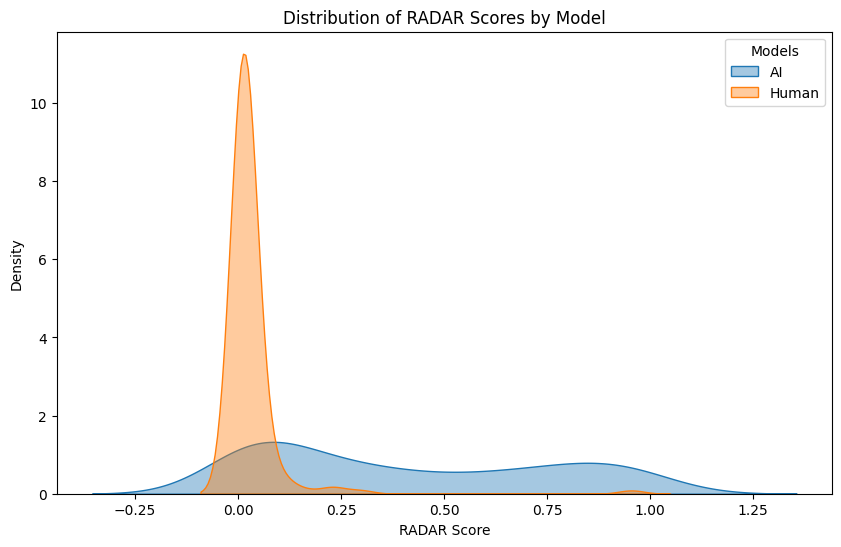

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Density")
plt.title("Distribution of RADAR Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

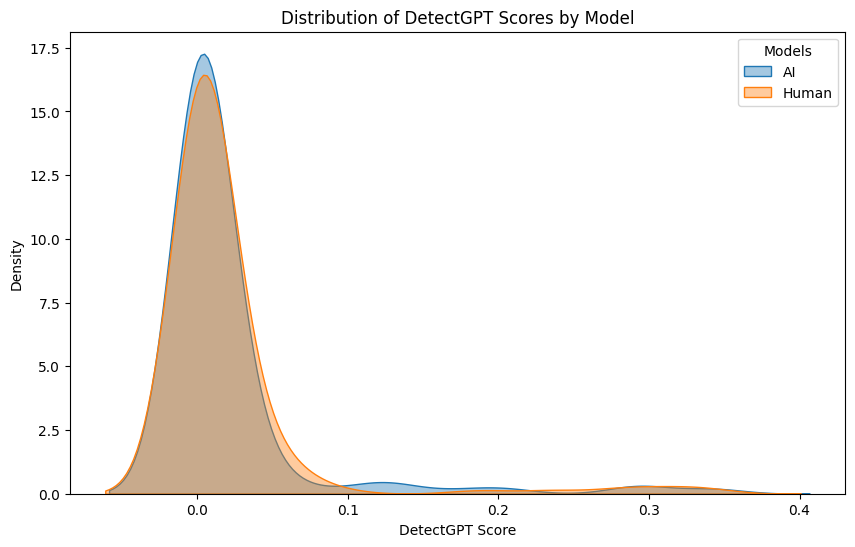

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Density")
plt.title("Distribution of DetectGPT Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

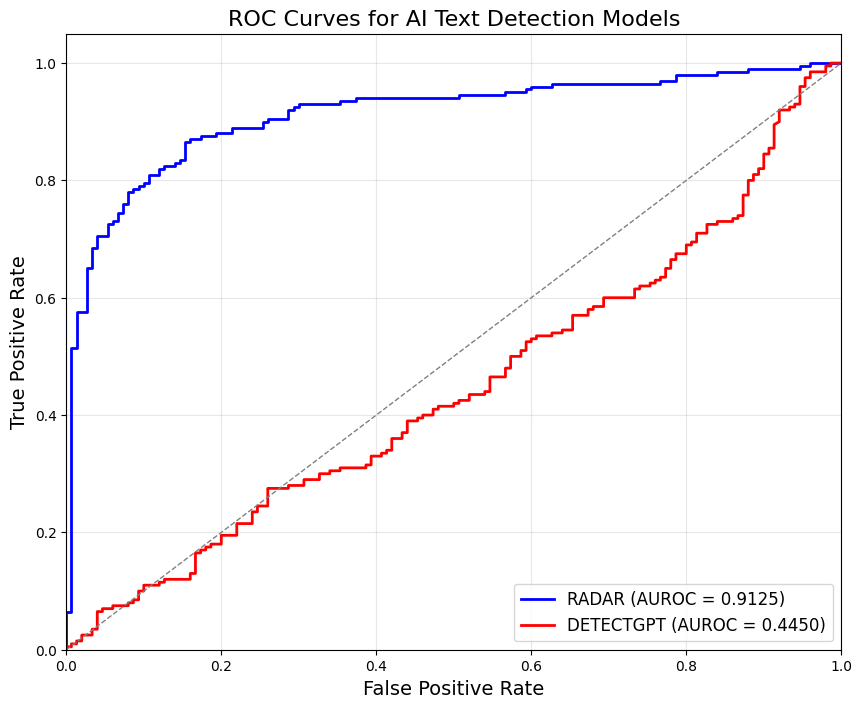

In [33]:
from sklearn.metrics import roc_curve

# Calculate ROC curve points for both detectors
fpr_radar, tpr_radar, _ = roc_curve(combined_df['label'], combined_df['radar_score'])
fpr_wild, tpr_wild, _ = roc_curve(combined_df['label'], combined_df['detectgpt_score'])

# Create a figure with appropriate size
plt.figure(figsize=(10, 8))

# Plot both ROC curves
plt.plot(fpr_radar, tpr_radar, color='blue', lw=2,
         label=f'RADAR (AUROC = {auroc_radar:.4f})')
plt.plot(fpr_wild, tpr_wild, color='red', lw=2,
         label=f'DETECTGPT (AUROC = {auroc_detectgpt:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Add labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for AI Text Detection Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

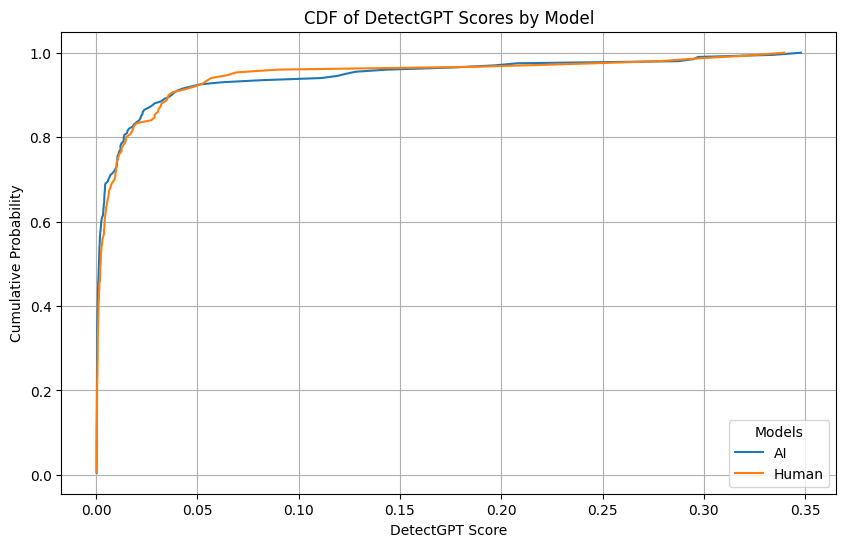

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of DetectGPT Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()

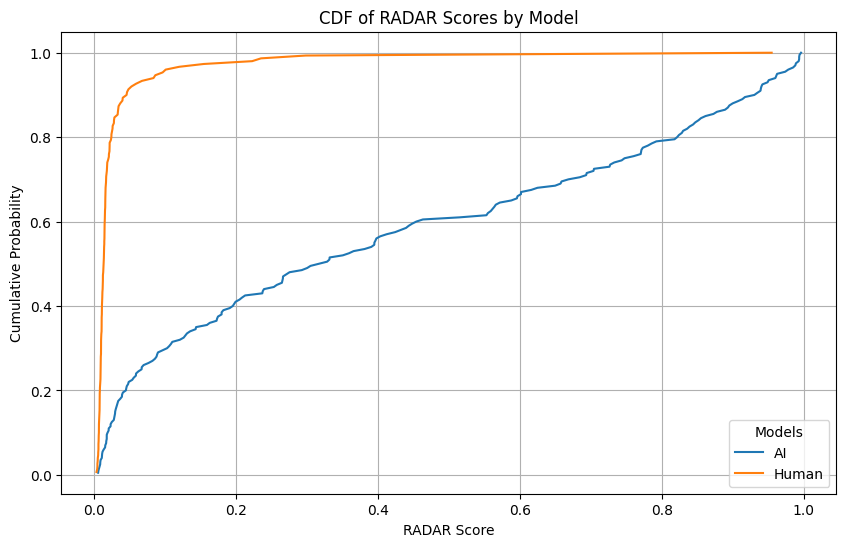

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of RADAR Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()